In [1]:
import os
os.chdir("..")

In [18]:
import wandb
import torch
from utils.models.mdn import MDN
from utils.data_module import VoestDataModule
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import subprocess

In [3]:
experiment_name = "config_voest_grid_search_run_with_error_handling"

In [4]:
api = wandb.Api()
runs = api.runs("alexanderkrauck/mdn_synthetic1")

In [5]:
for run in [r for r in runs if experiment_name in r.name]:
    print(run.name, run.state, run.summary["test_loss"] if "test_loss" in run.summary else None,run.summary["best_val_loss"] if "best_val_loss" in run.summary else None)

config_voest_grid_search_run_with_error_handling_cnf0_seed_44 crashed None None
config_voest_grid_search_run_with_error_handling_cnf0_seed_43 finished 5.084305803285069 4.856024217765783
config_voest_grid_search_run_with_error_handling_cnf0_seed_42 finished 5.056920744363309 4.848747694834972
config_voest_grid_search_run_with_error_handling_cnf0_seed_42 crashed None None
config_voest_grid_search_run_with_error_handling_cnf1_seed_42 crashed None None
config_voest_grid_search_run_with_error_handling_cnf0_seed_44 finished 5.148423457016672 4.924161779297604
config_voest_grid_search_run_with_error_handling_cnf0_seed_43 finished 5.141398776353885 4.916257851868701
config_voest_grid_search_run_with_error_handling_cnf0_seed_42 finished 5.136406273689704 4.904115614939109
config_voest_grid_search_run_with_error_handling_cnf0_seed_42 crashed None None
config_voest_grid_search_run_with_error_handling_cnf20_seed_42 killed None None
config_voest_grid_search_run_with_error_handling_cnf19_seed_44 fi

In [6]:
best_run = [r for r in runs if "config_voest_grid_search_run_with_error_handling_cnf17_seed_44" == r.name][0]

In [19]:
print(best_run.summary)
print(best_run.state)
run_id = best_run.id
find_command = f"find {'wandb'} -type d -name '*{run_id}'"

# Execute the command
process = subprocess.Popen(find_command, shell=True, stdout=subprocess.PIPE)
stdout, stderr = process.communicate()

# Extract the directory path from the command output
run_directory_path = stdout.decode().strip()
print(run_directory_path)
best_run.config

{'test_loss': 6.10765634612553, 'best_val_loss': 4.738847904127006, 'gradients/graph_51mlp.output_layer.weight': {'_type': 'histogram', 'bins': [-2.996093988418579, -2.9018592834472656, -2.8076248168945312, -2.7133901119232178, -2.6191556453704834, -2.52492094039917, -2.4306864738464355, -2.336451768875122, -2.2422170639038086, -2.147982597351074, -2.0537478923797607, -1.9595134258270264, -1.865278720855713, -1.771044135093689, -1.676809549331665, -1.5825749635696411, -1.4883403778076172, -1.3941057920455933, -1.2998712062835693, -1.2056366205215454, -1.1114020347595215, -1.017167329788208, -0.9229327440261841, -0.8286981582641602, -0.7344635725021362, -0.6402289867401123, -0.5459944009780884, -0.4517597556114197, -0.35752516984939575, -0.2632905840873718, -0.1690559685230255, -0.0748213678598404, 0.019413471221923828, 0.11364807188510895, 0.20788267254829407, 0.3021172881126404, 0.3963518738746643, 0.49058645963668823, 0.5848211050033569, 0.6790556907653809, 0.7732902765274048, 0.8675

{'model_hyperparameters': {'n_hidden': [64, 64],
  'dropout_rate': 0,
  'n_distributions': 20,
  'distribution_type': 'gaussian',
  'activation_function': 'tanh'},
 'training_hyperparameters': {'epochs': 150,
  'optimizer': 'Adam',
  'batch_size': 128,
  'input_noise_x': 0.2,
  'input_noise_y': 0.1,
  'loss_hyperparameters': {'reliability_loss_weight': 0},
  'optimizer_hyperparameters': {'lr': 0.001,
   'eps': 1e-08,
   'betas': [0.9, 0.999],
   'weight_decay': 1e-07}}}

In [20]:
best_run.file("best_params.pt")

<File best_params.pt (application/vnd.snesdev-page-table) 48.7KiB>

In [21]:
data_module = VoestDataModule()

/mnt/92669E5D669E4241/uncertainty_prediction/utils/data_module.py:281: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(self.x_total, axis=0)
/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
model = MDN(data_module, **best_run.config["model_hyperparameters"])
model.load_state_dict(torch.load(os.path.join(run_directory_path, "files", "best_params.pt")))
model.eval()

MDN(
  (mlp): MLP(
    (dropout): Dropout(p=0, inplace=False)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=51, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
    (output_layer): Linear(in_features=64, out_features=60, bias=True)
    (activation_function): Tanh()
  )
)

In [31]:
print(model.mlp.output_layer.weight.data.abs().max())
print(model.mlp.output_layer.bias.data.abs().max())

tensor(3.1303)
tensor(0.6263)


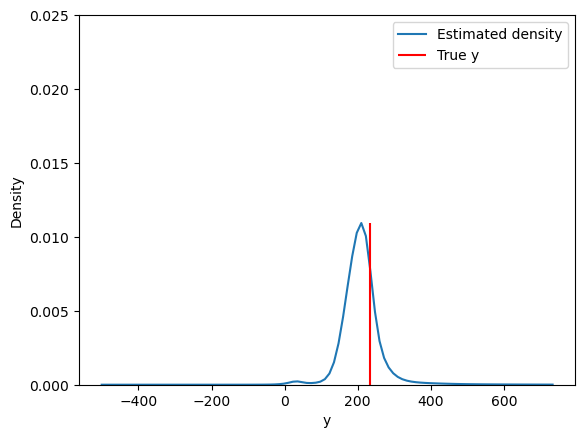

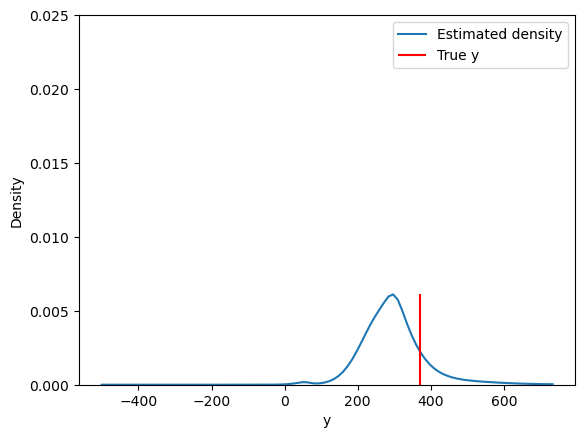

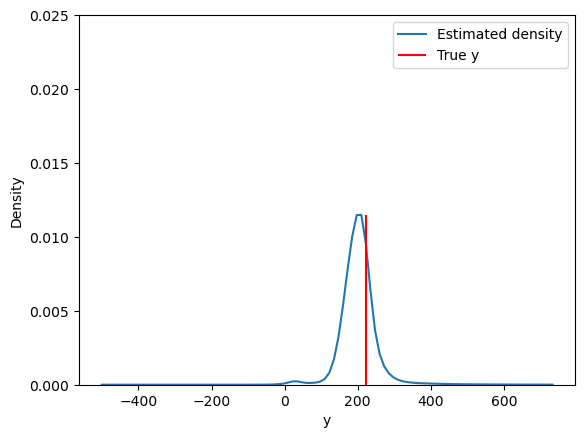

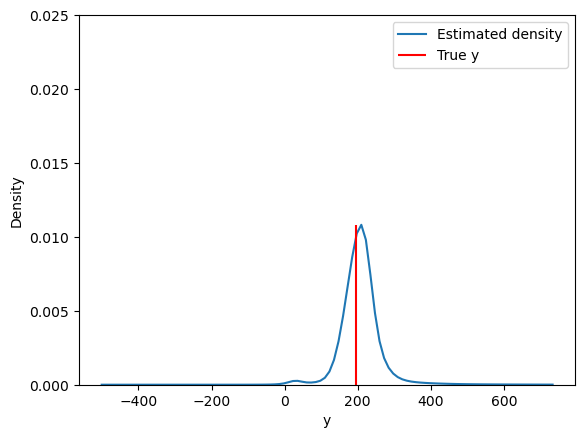

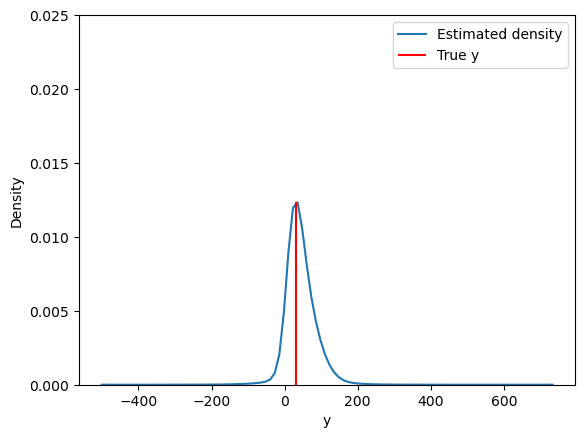

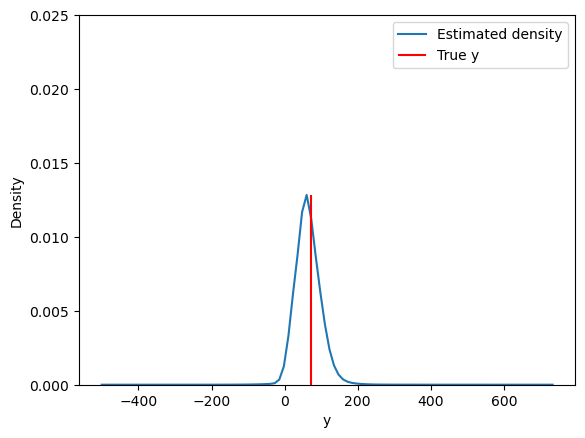

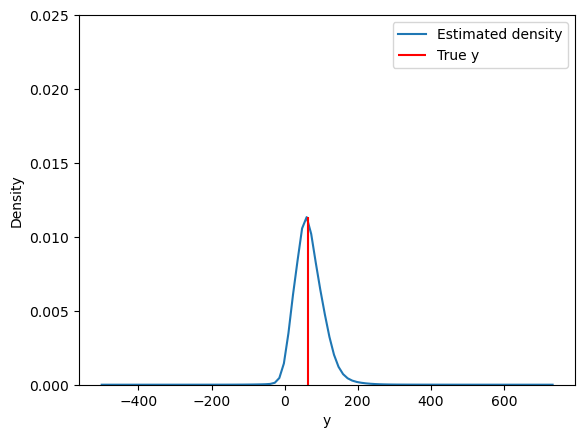

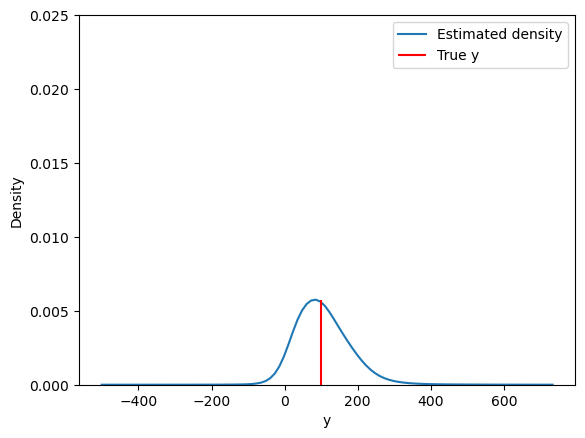

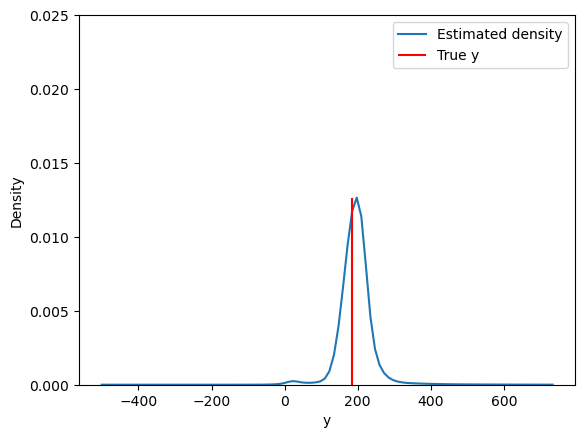

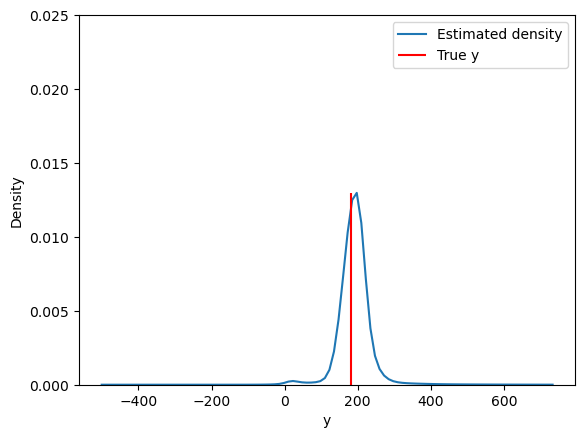

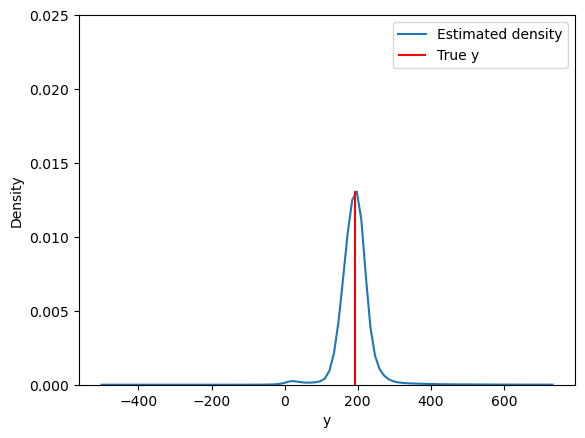

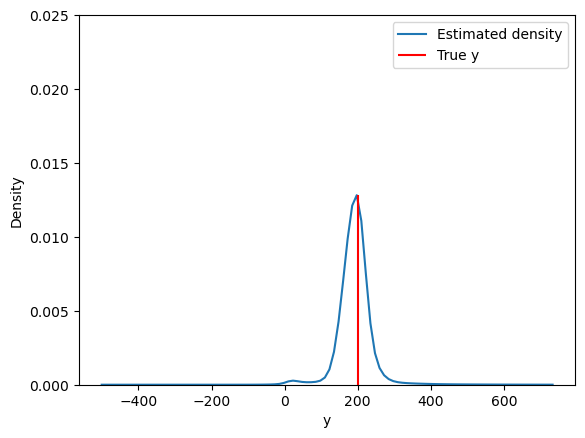

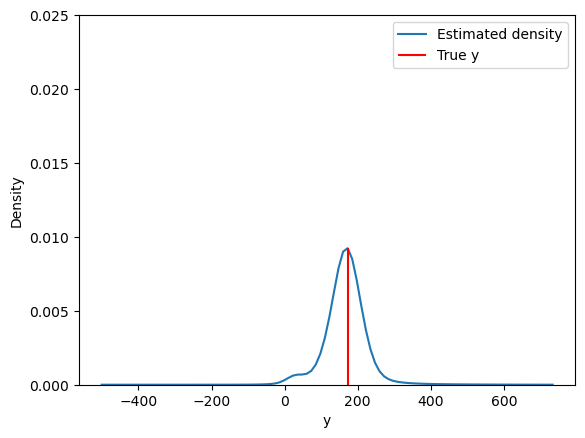

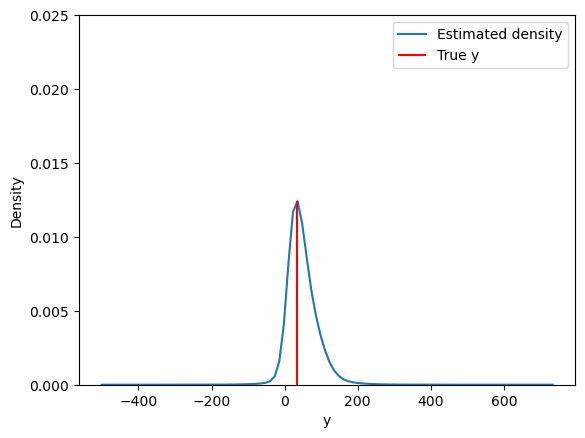

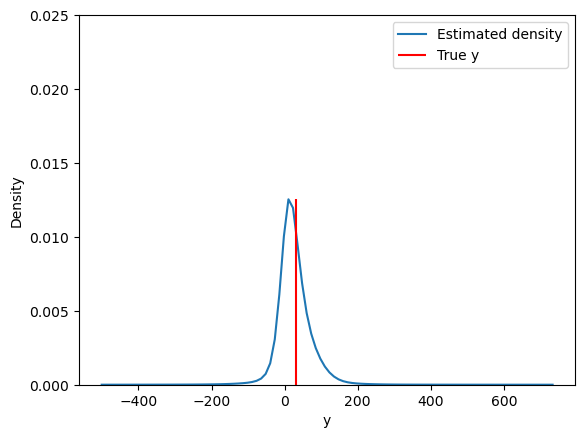

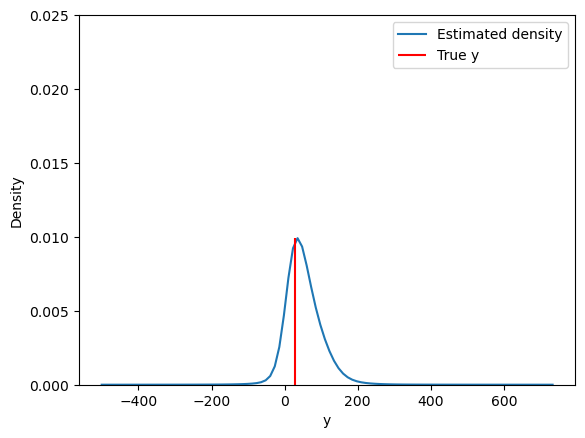

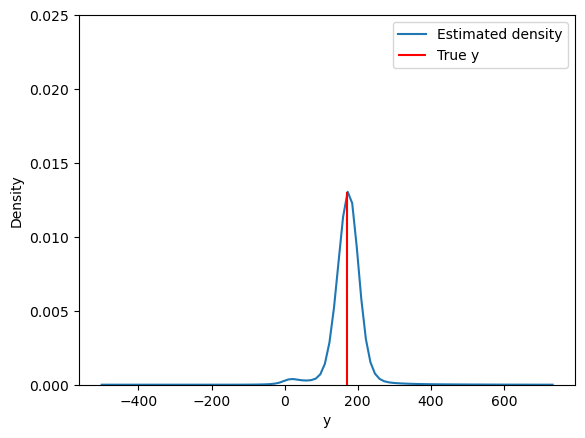

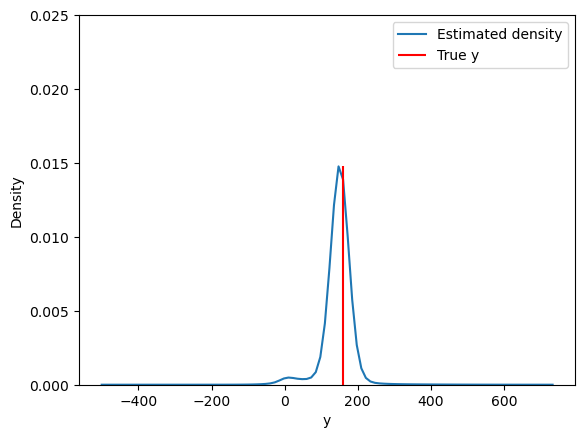

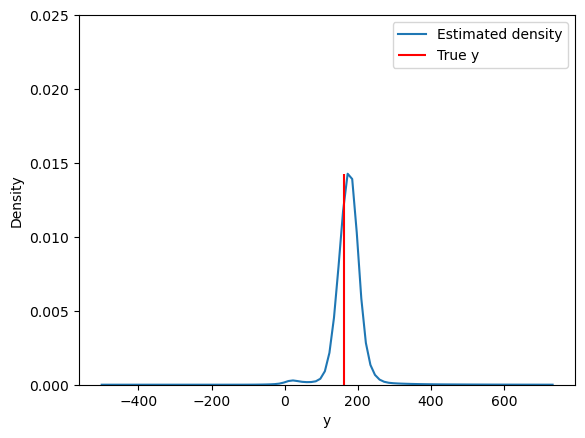

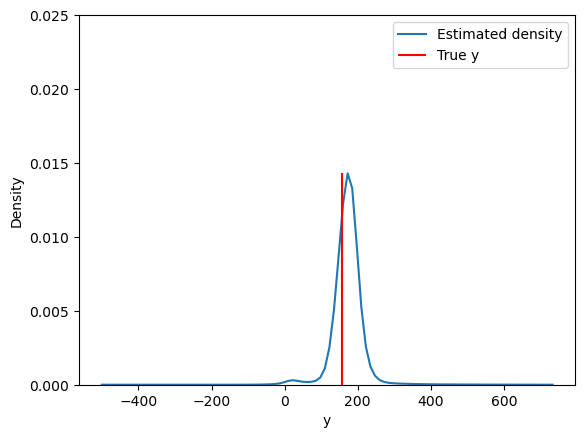

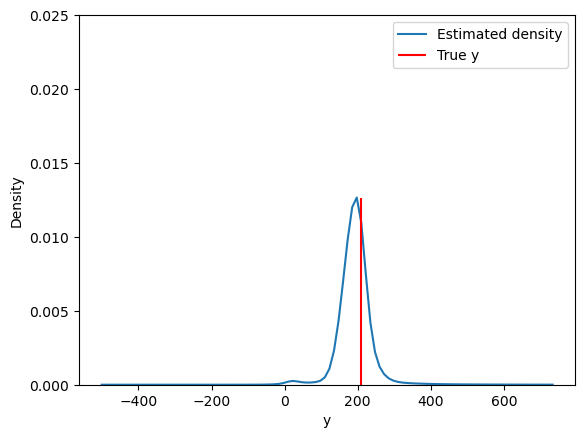

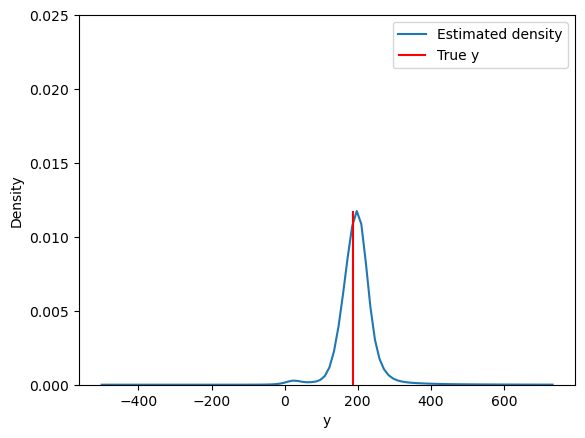

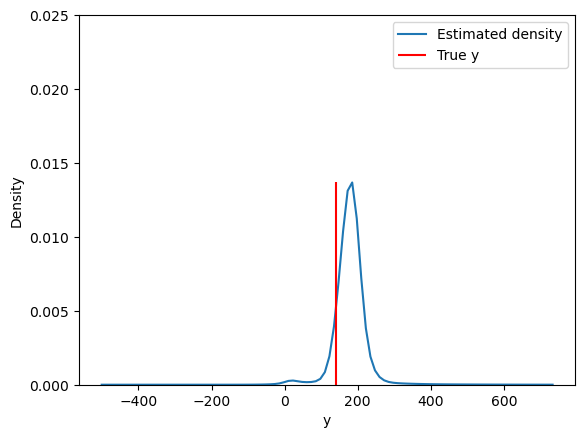

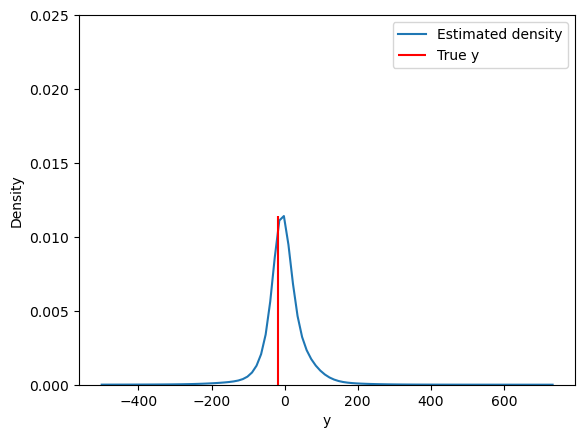

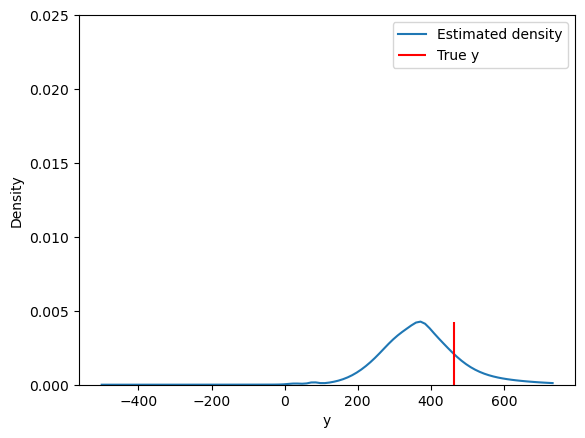

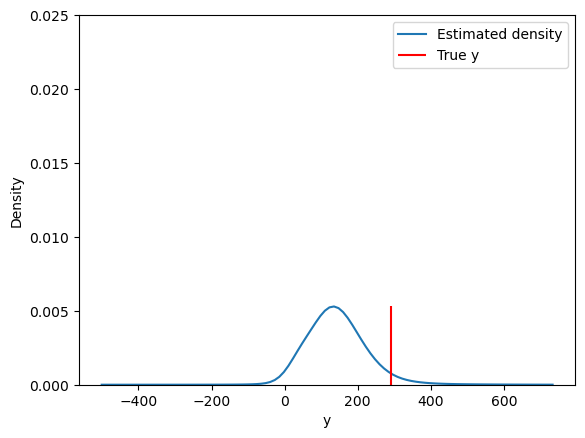

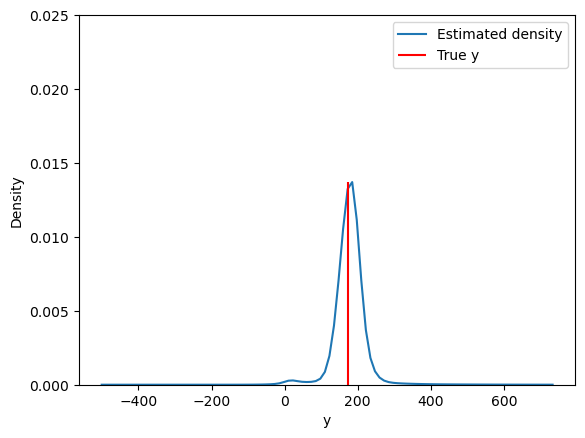

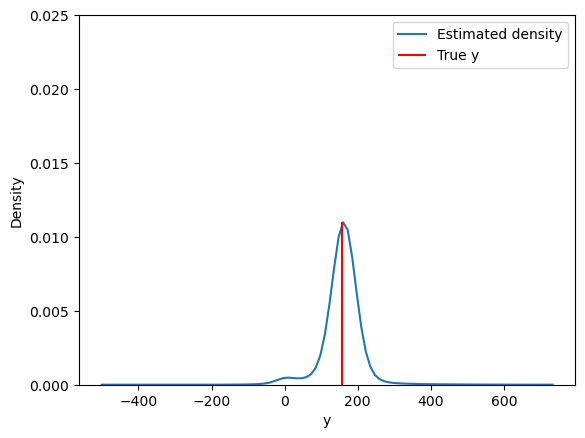

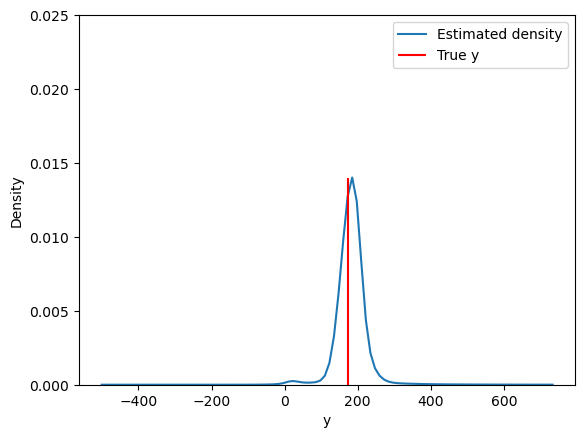

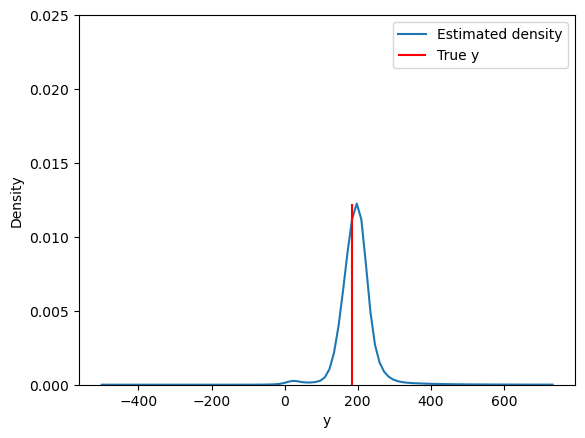

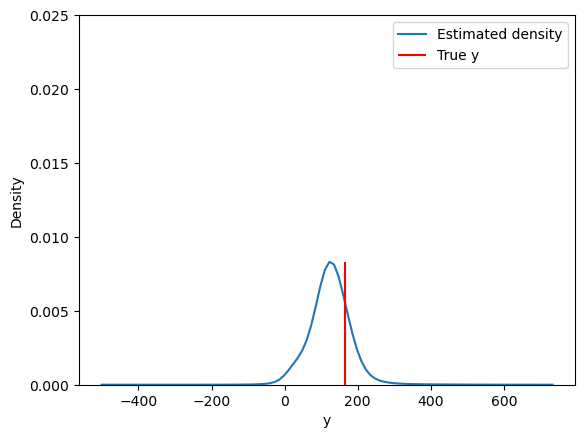

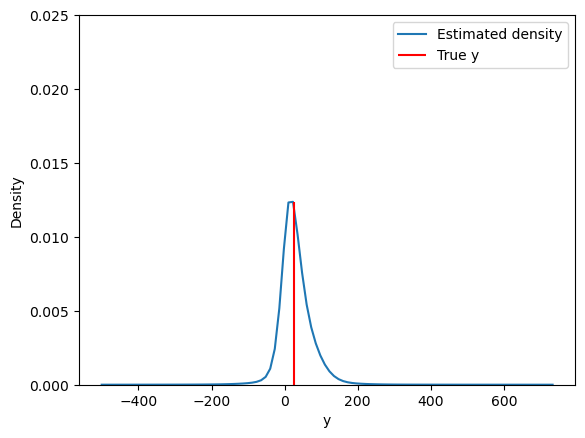

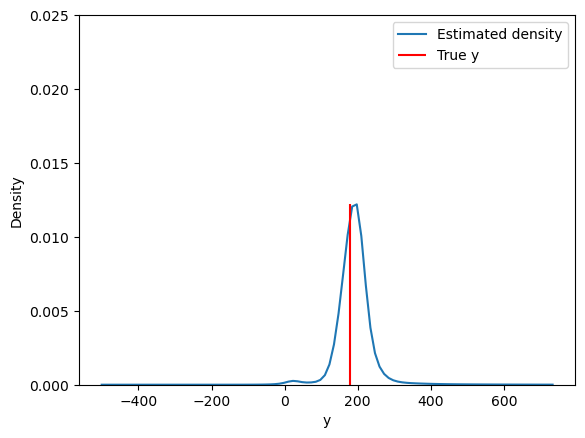

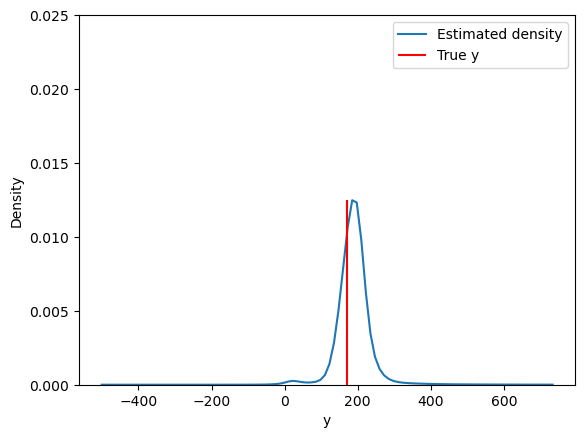

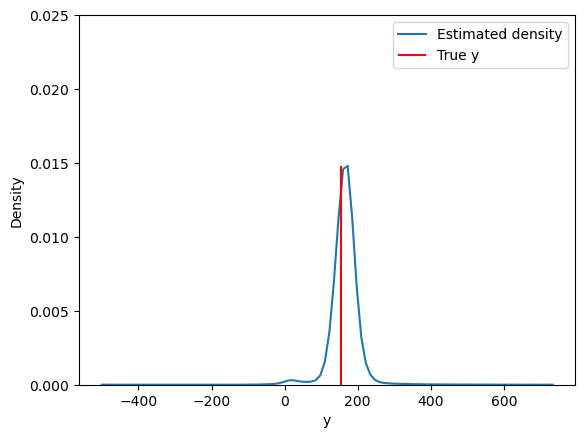

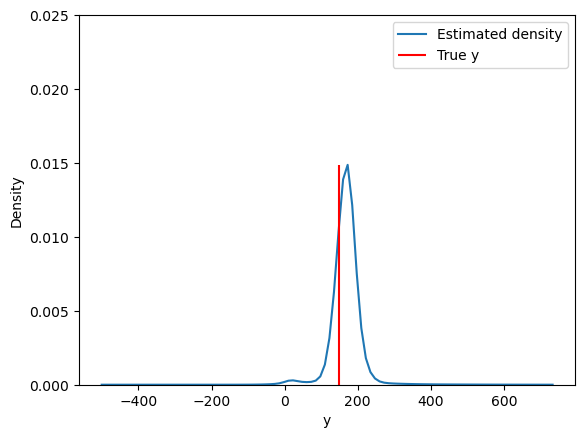

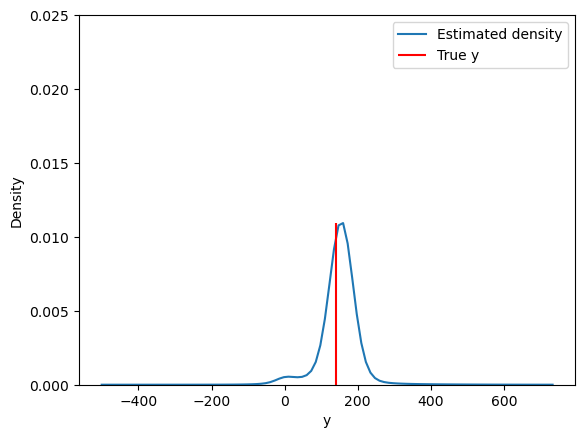

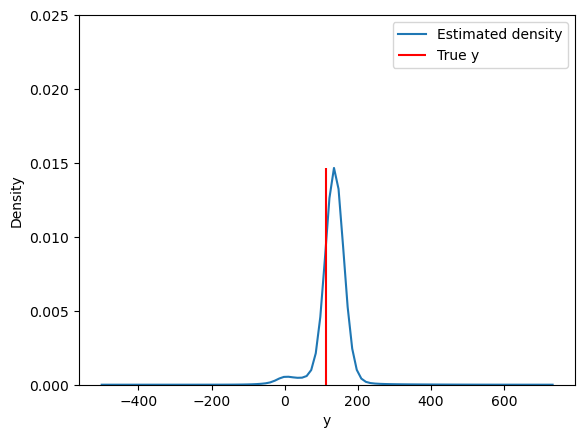

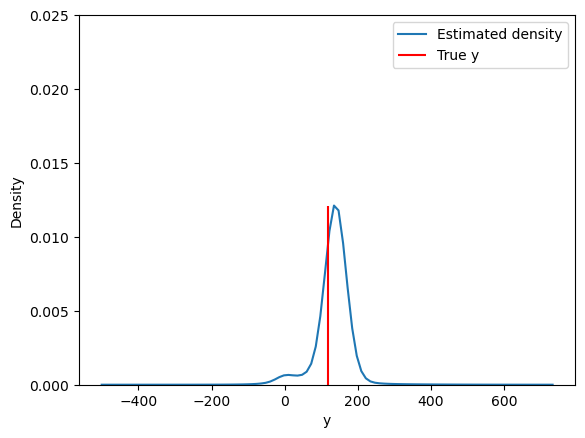

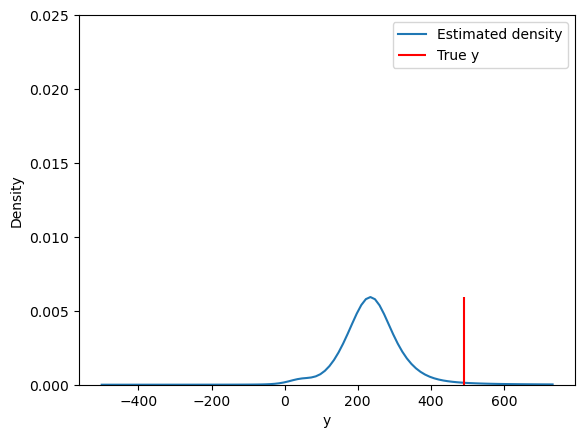

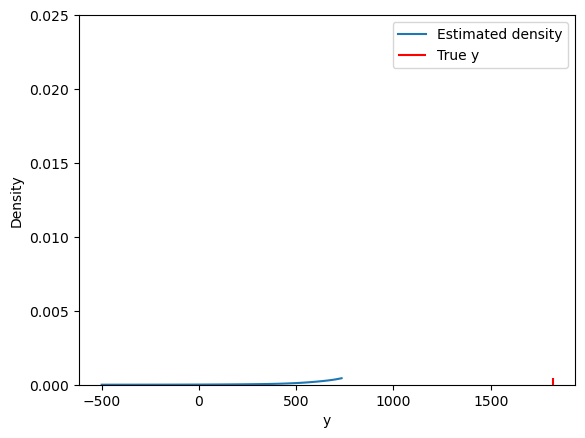

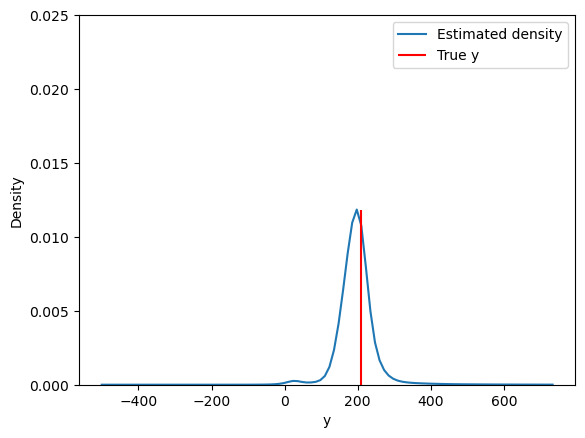

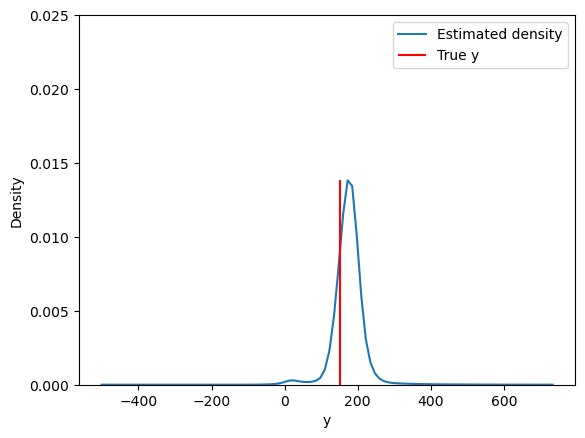

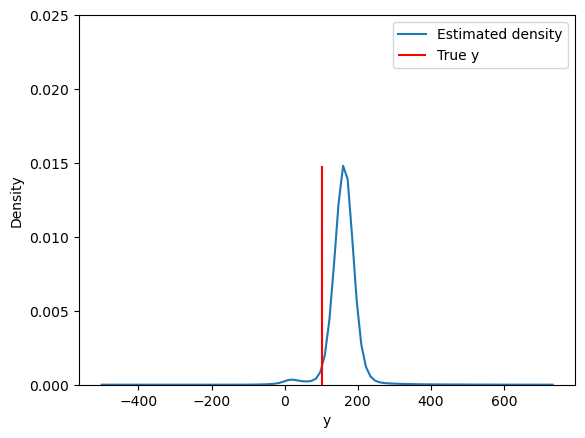

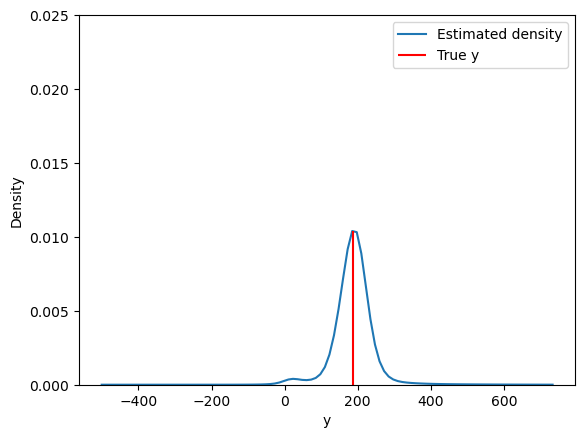

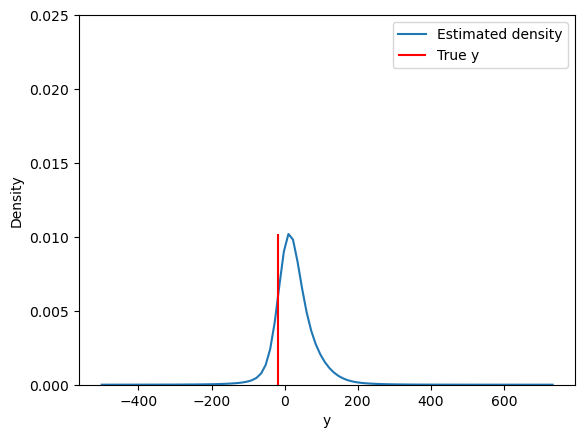

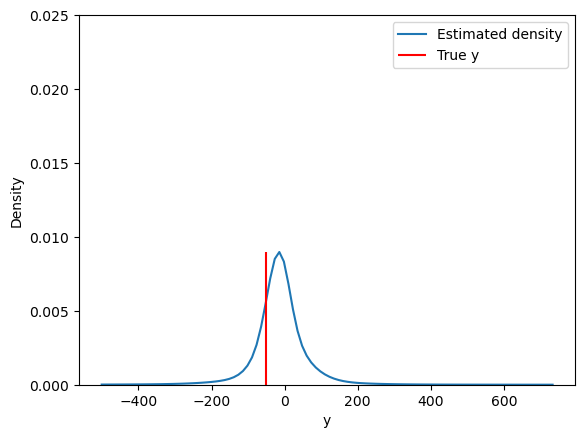

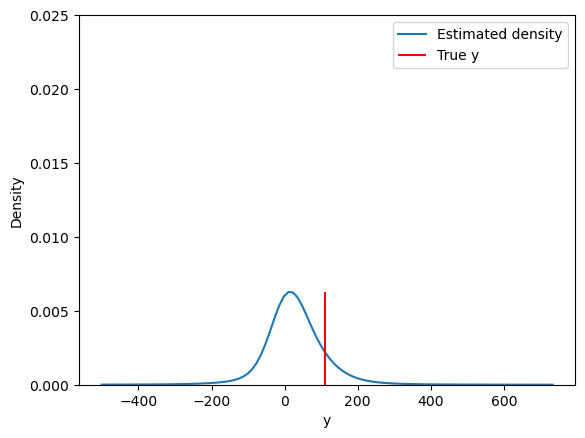

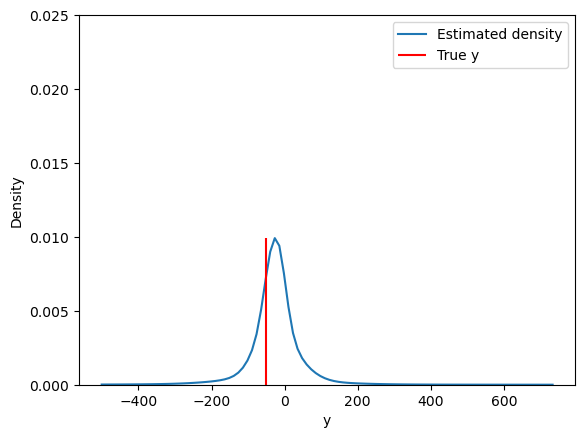

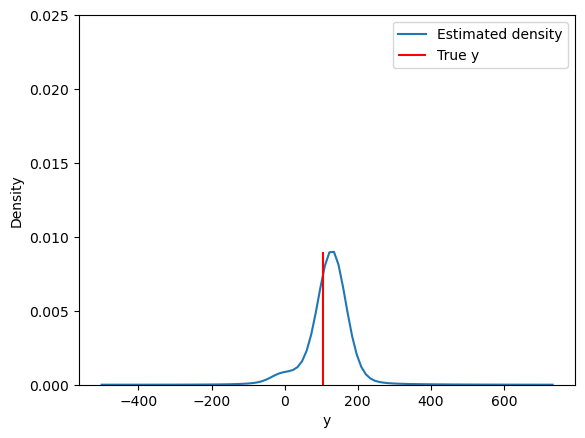

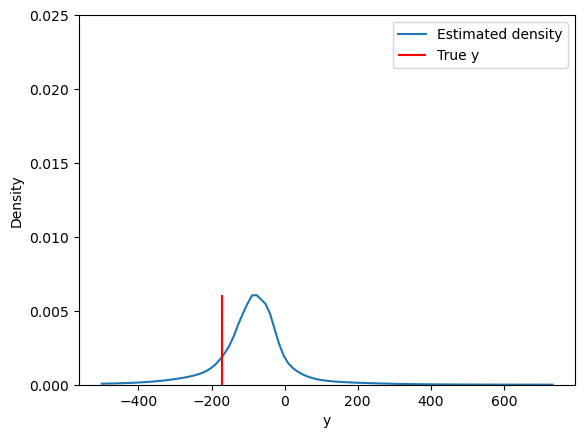

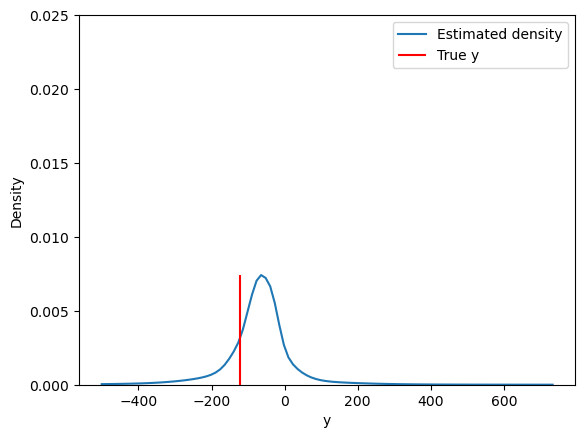

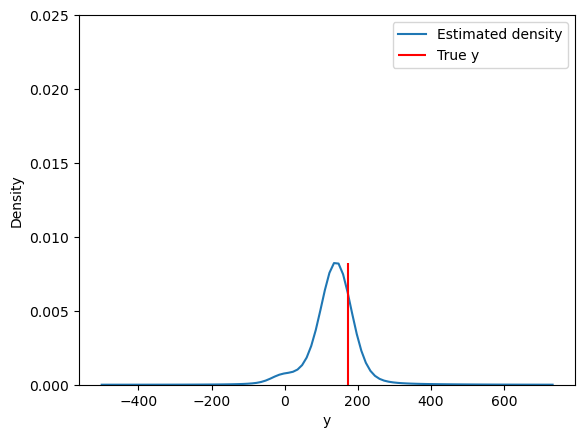

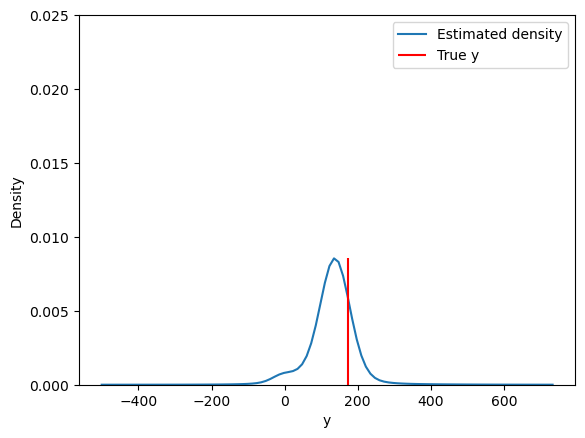

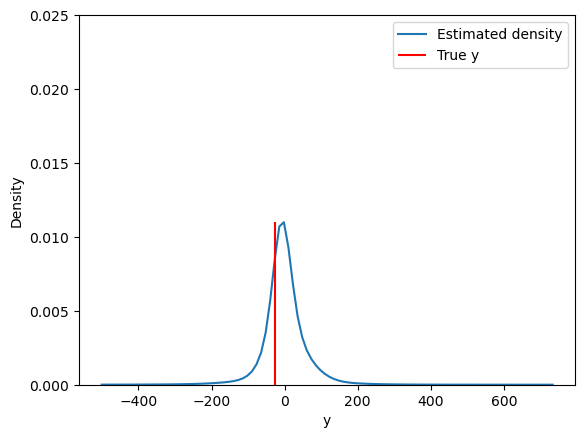

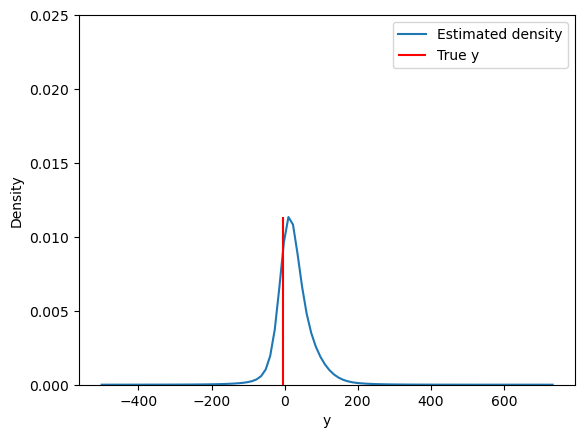

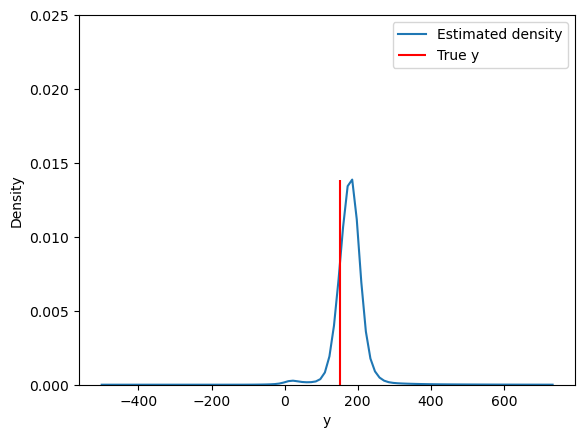

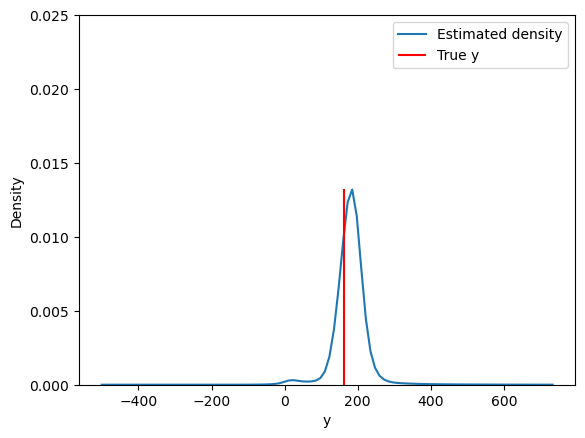

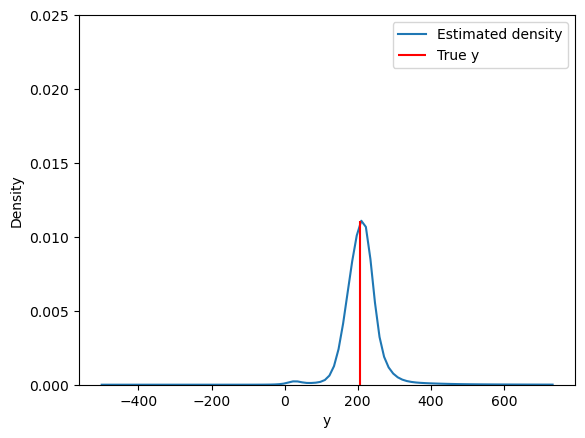

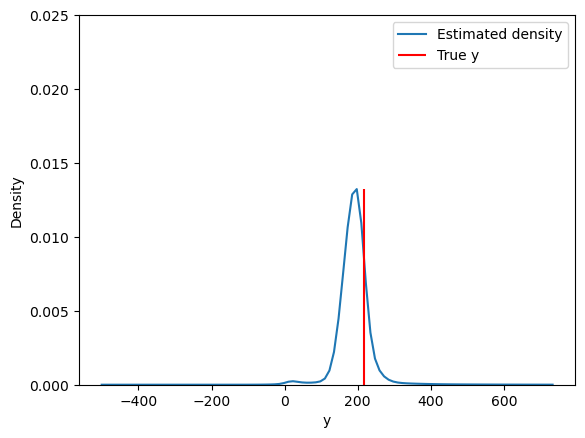

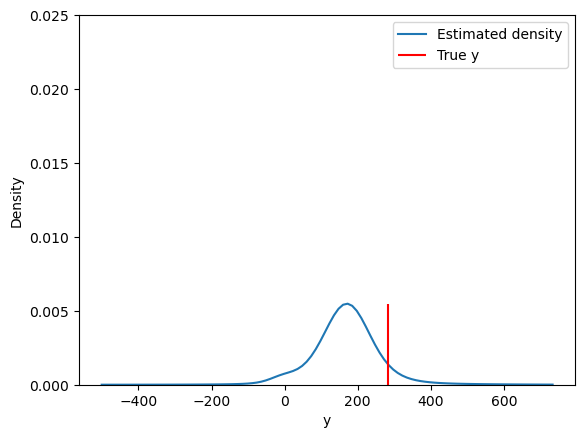

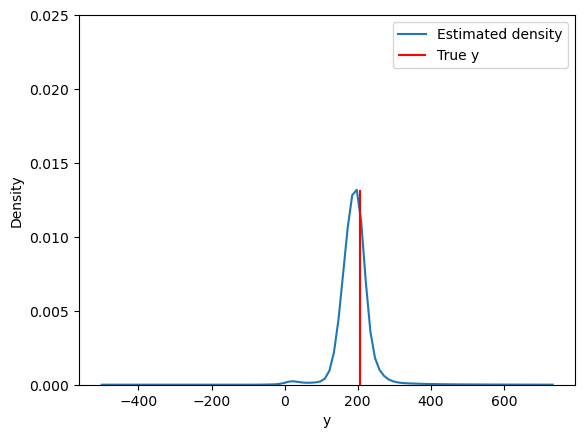

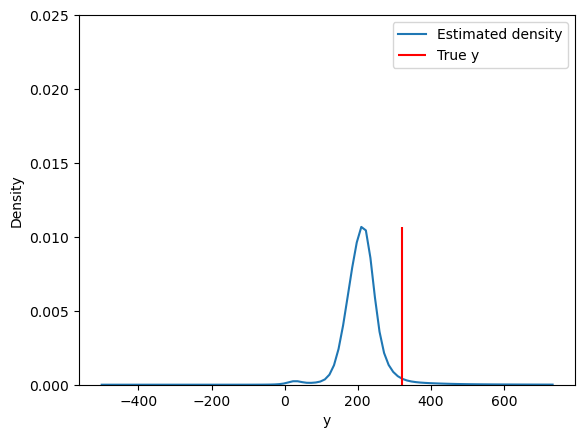

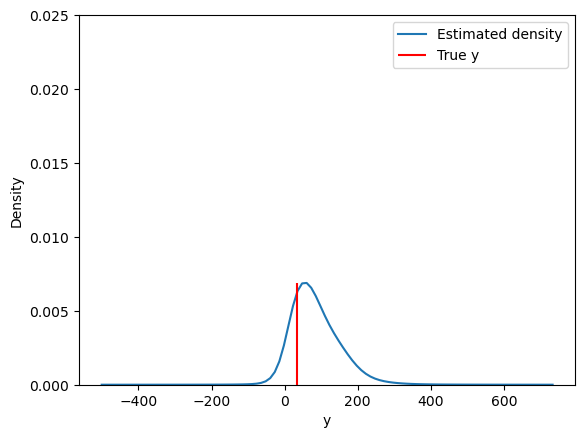

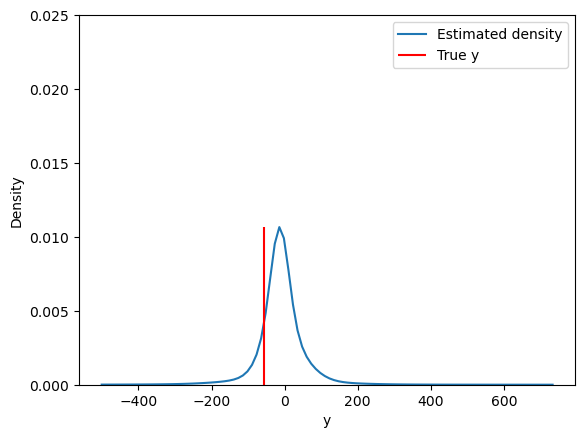

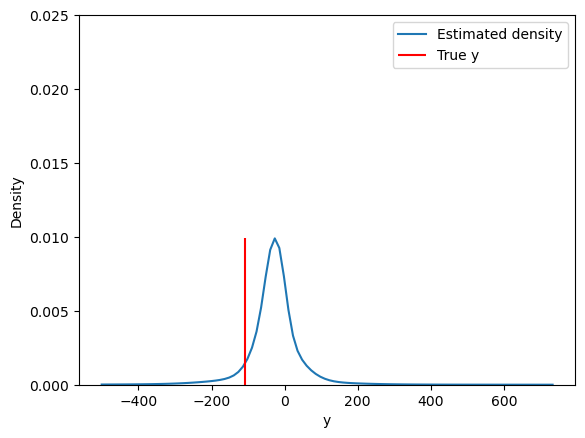

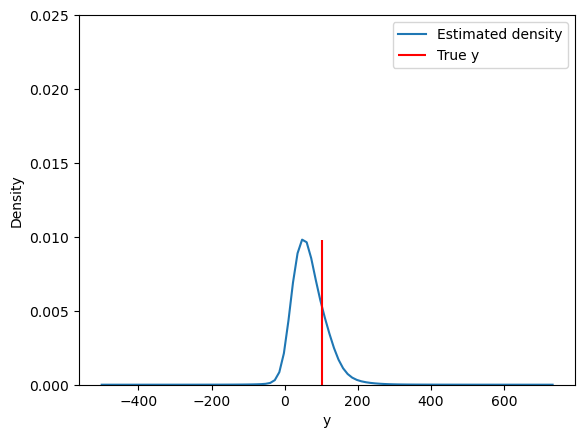

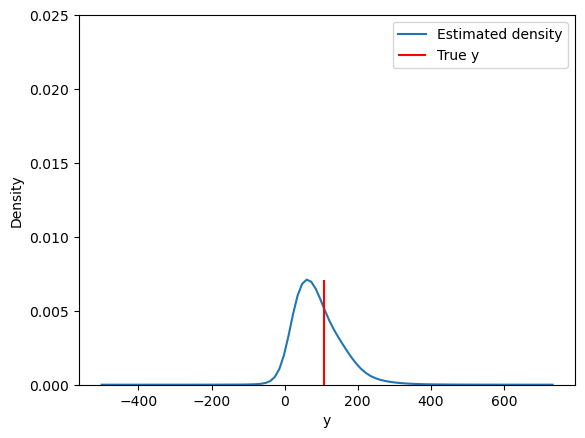

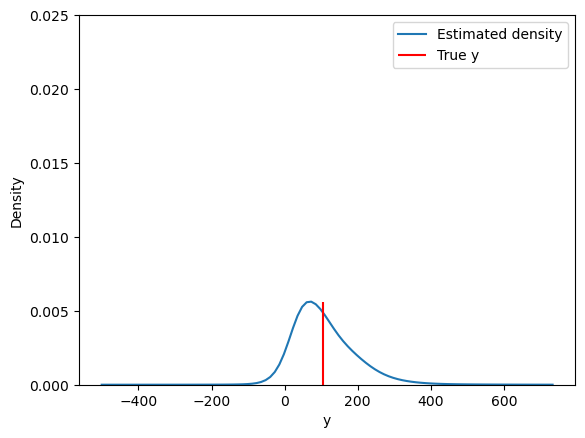

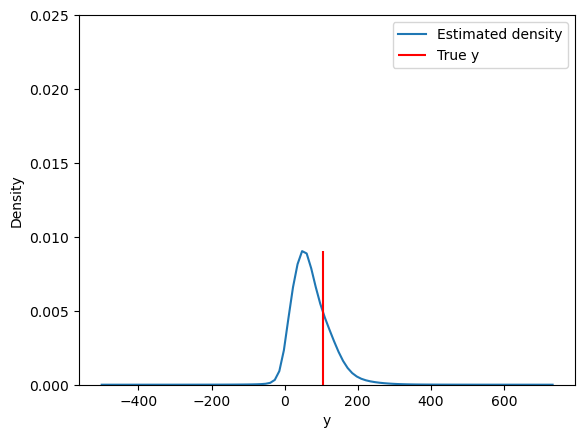

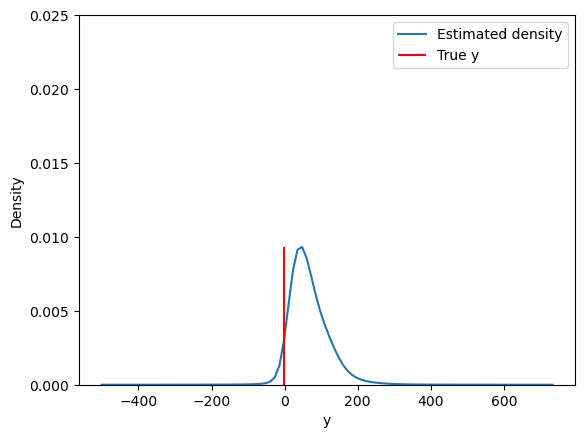

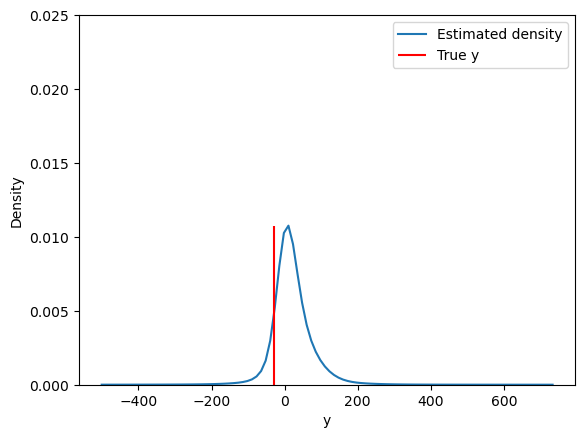

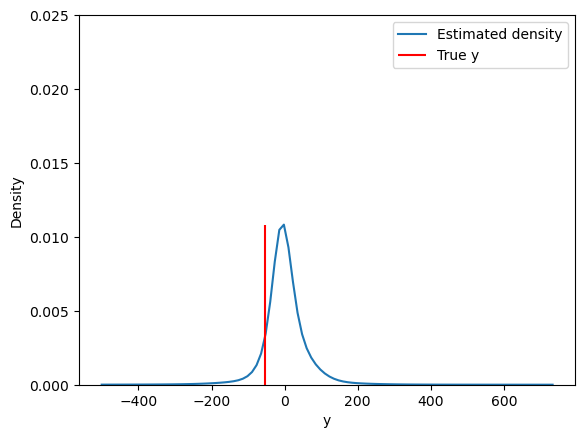

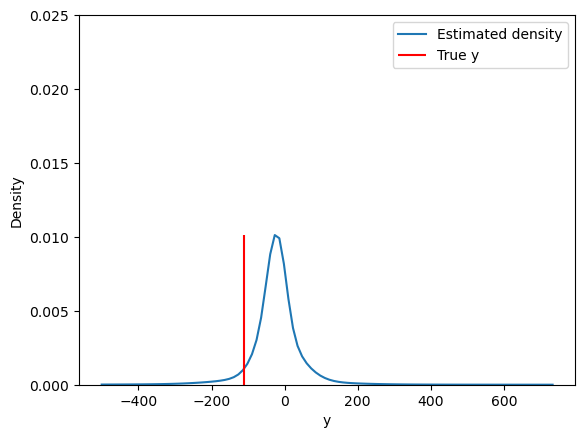

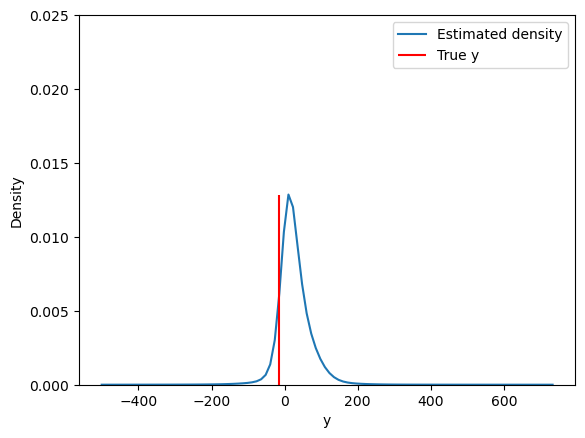

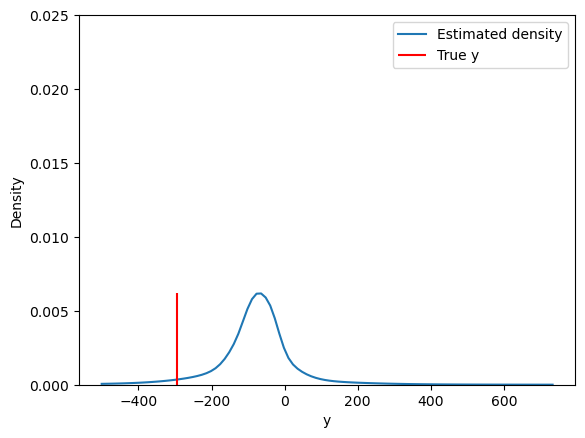

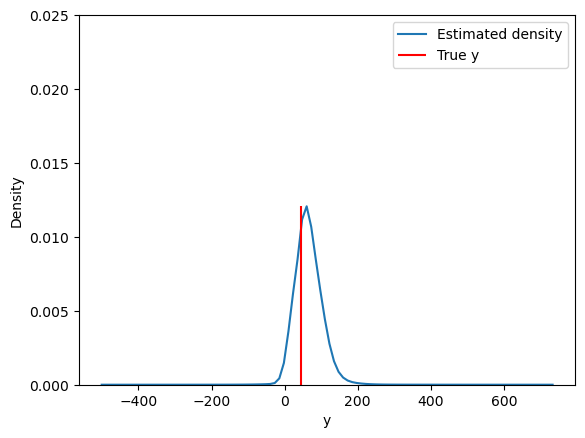

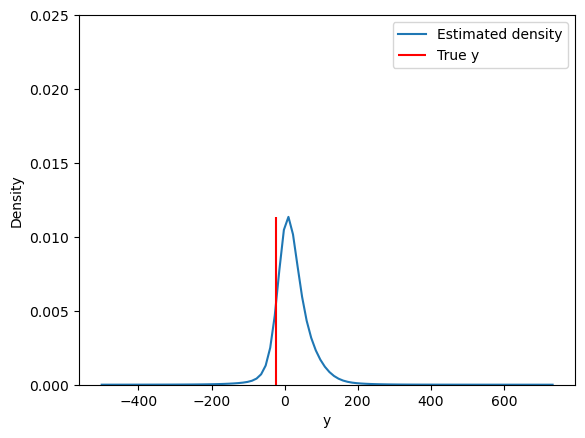

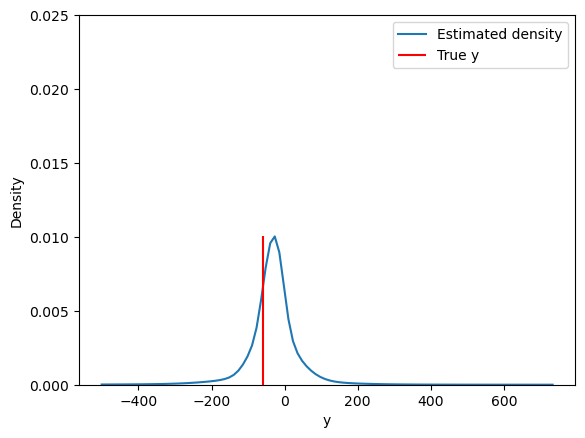

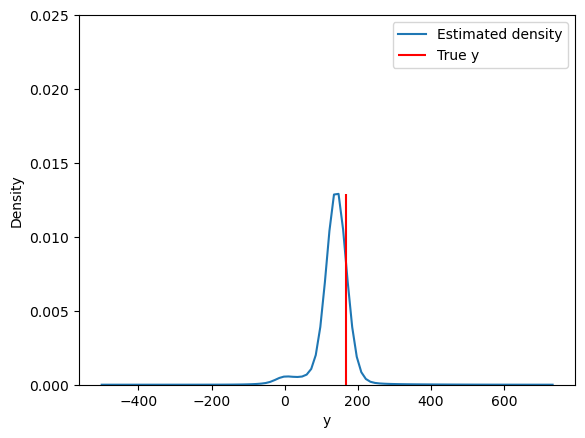

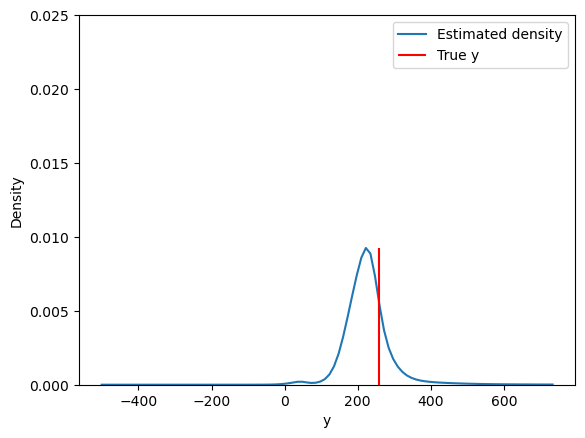

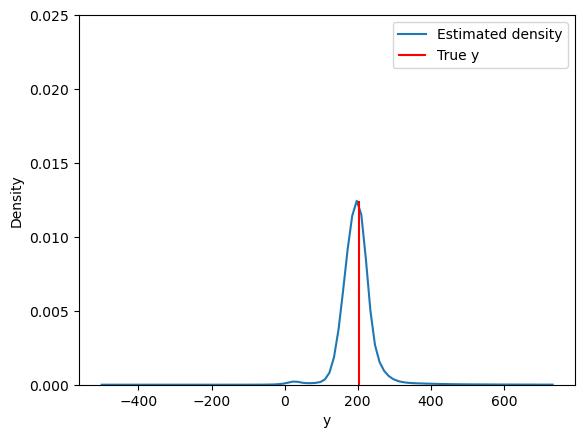

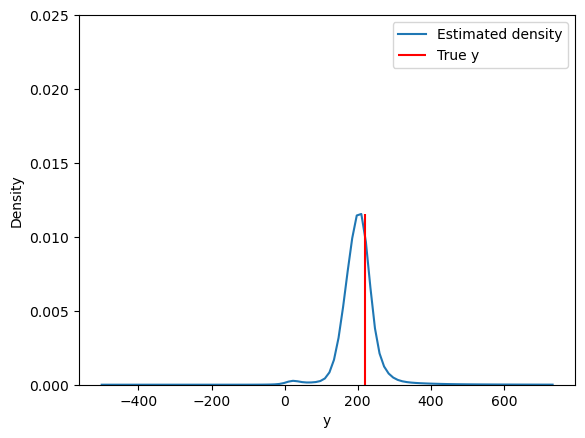

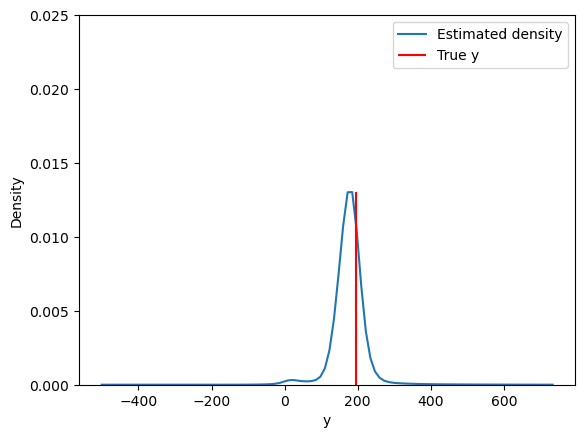

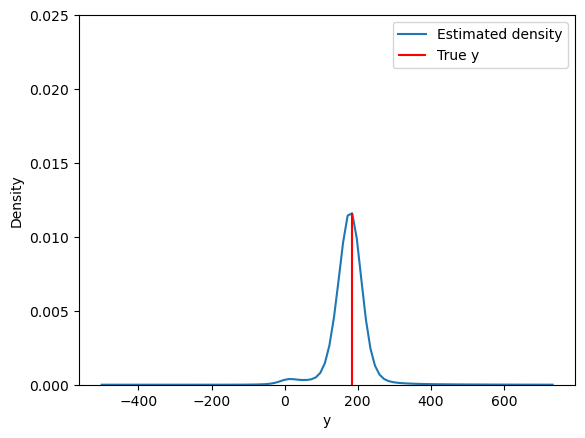

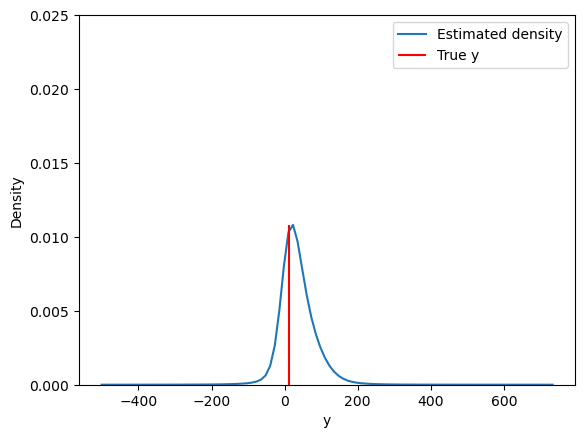

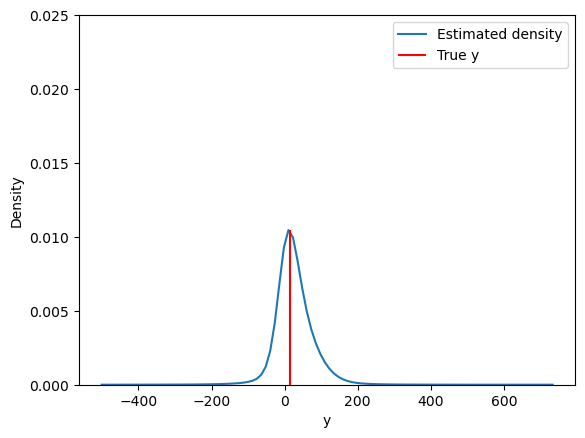

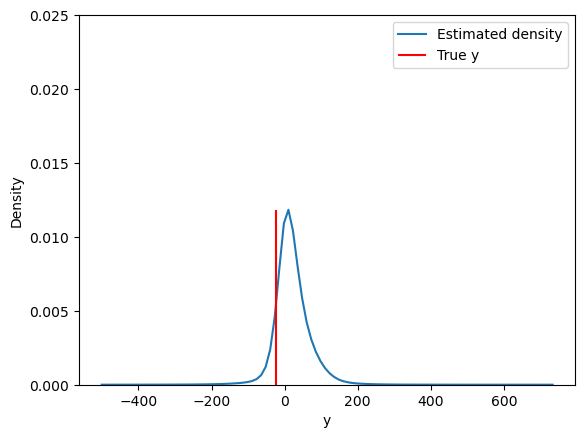

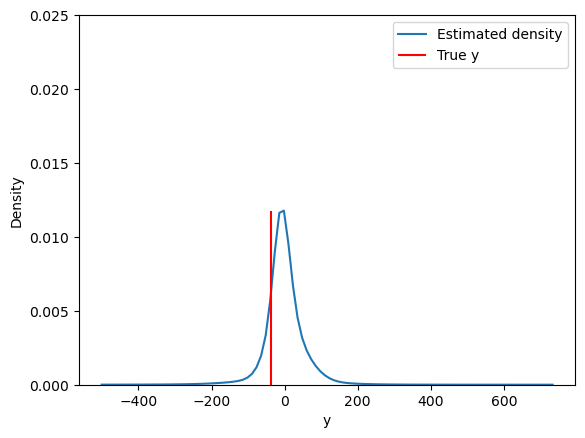

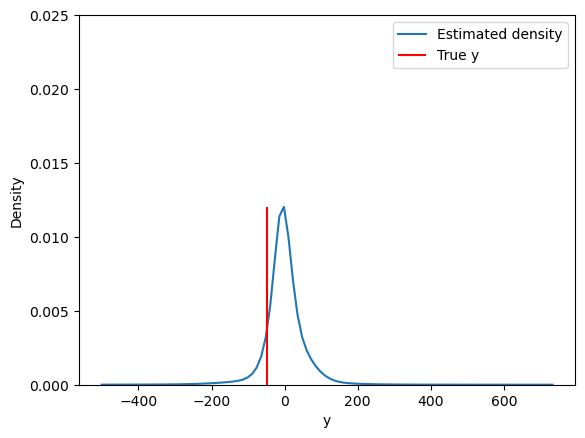

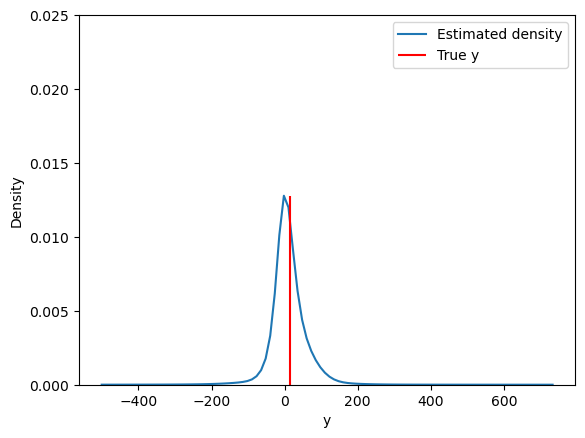

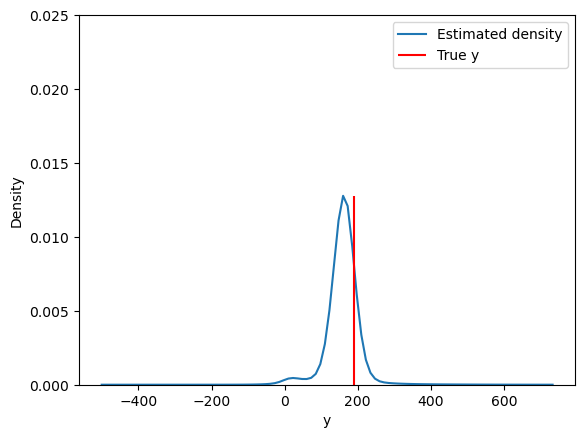

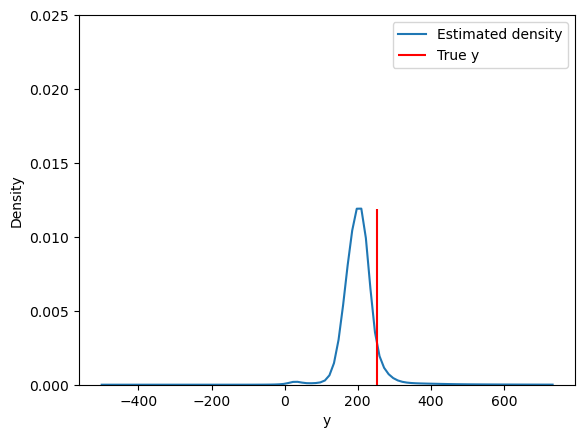

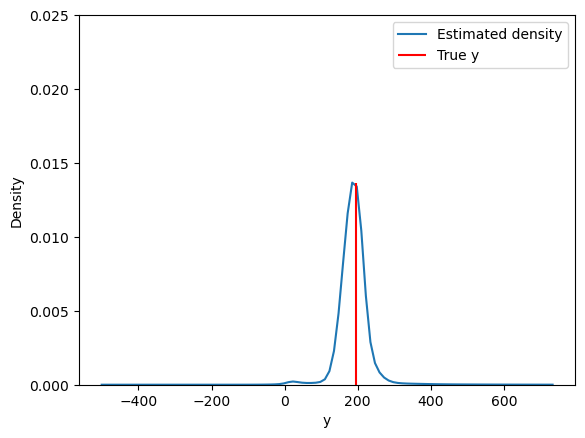

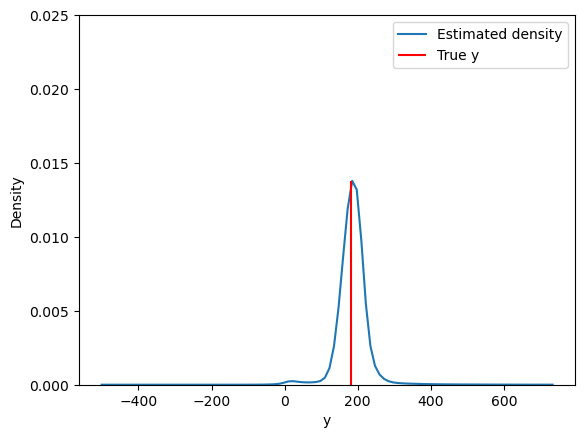

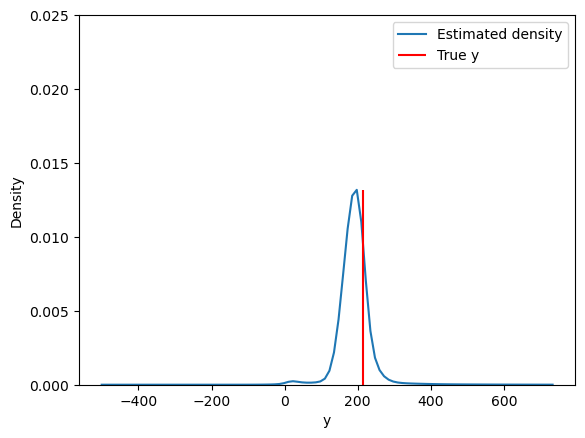

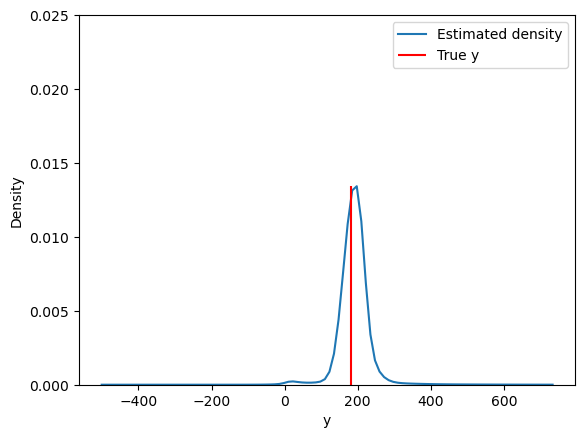

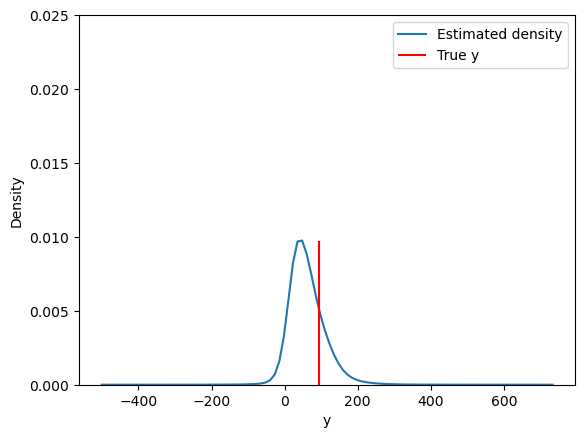

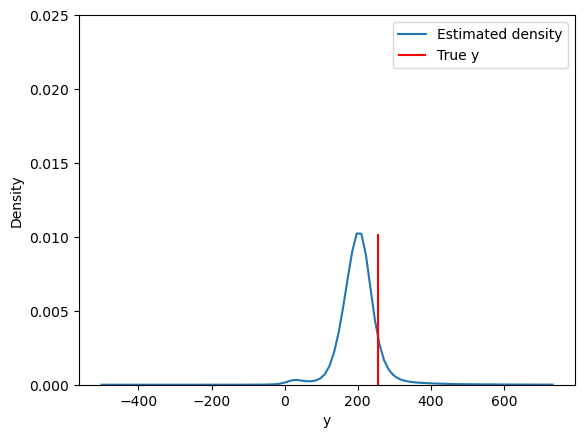

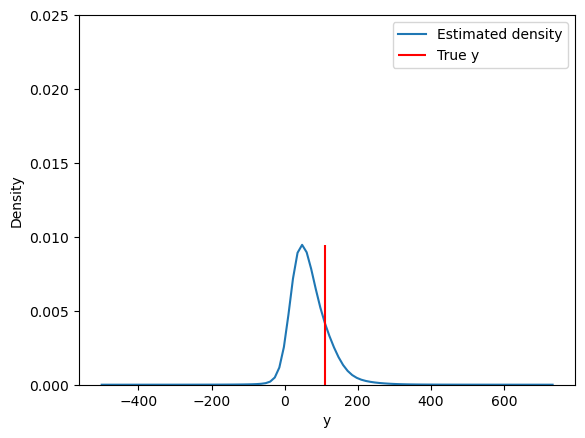

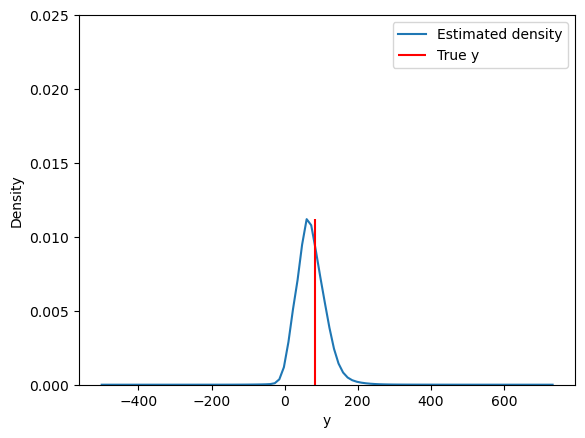

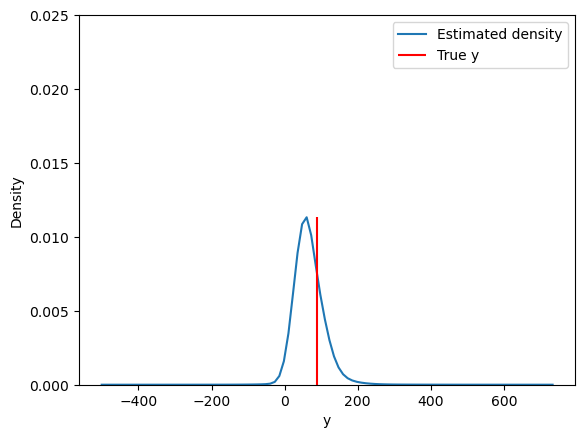

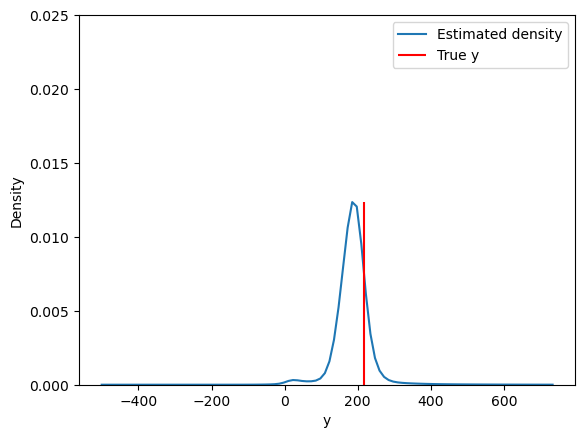

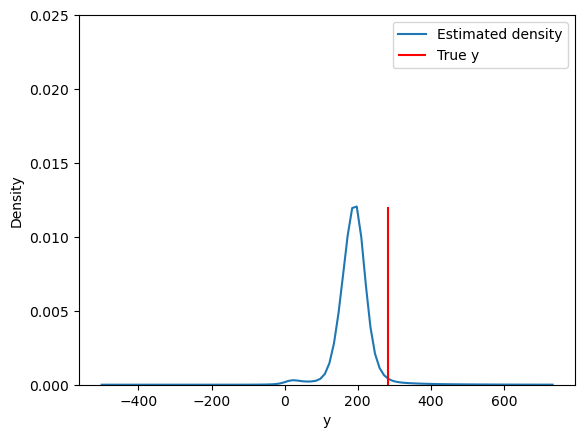

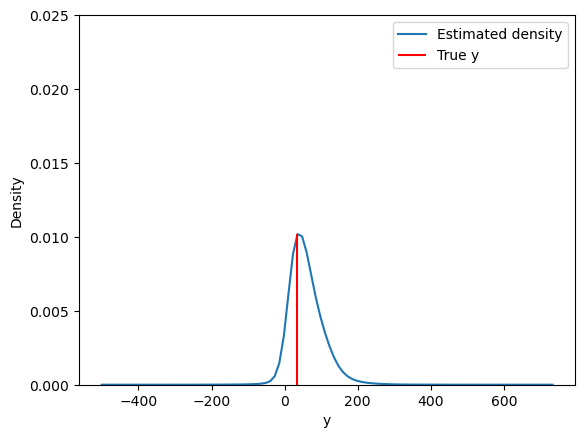

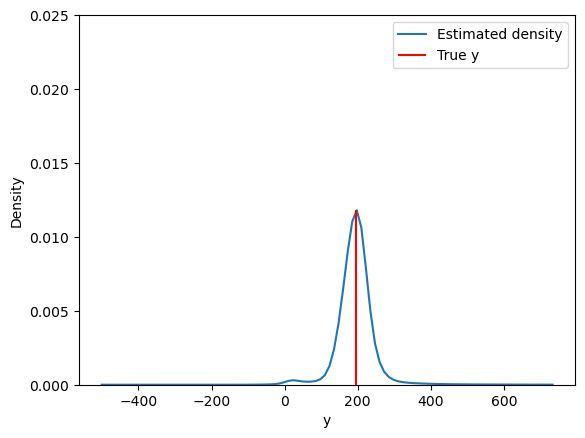

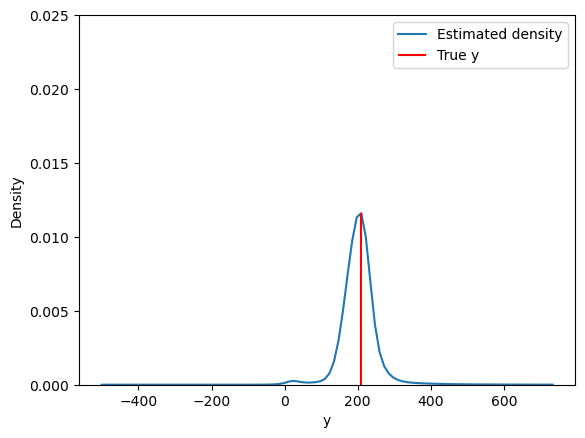

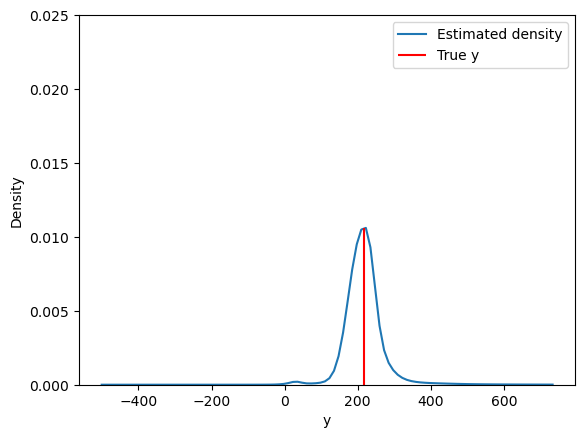

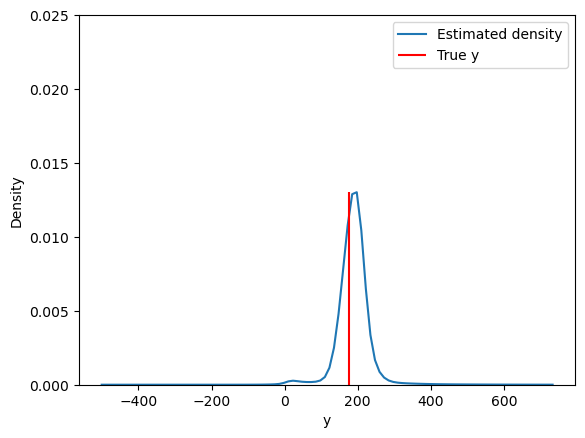

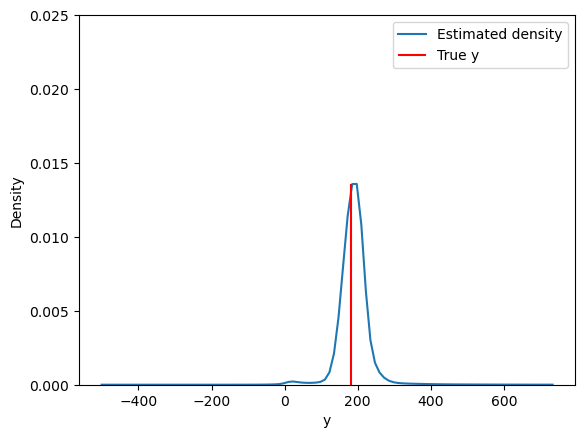

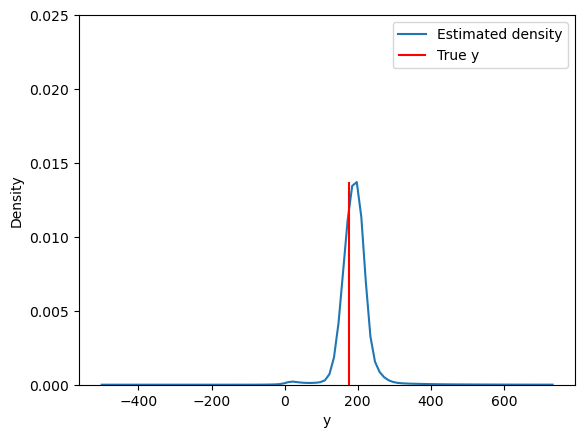

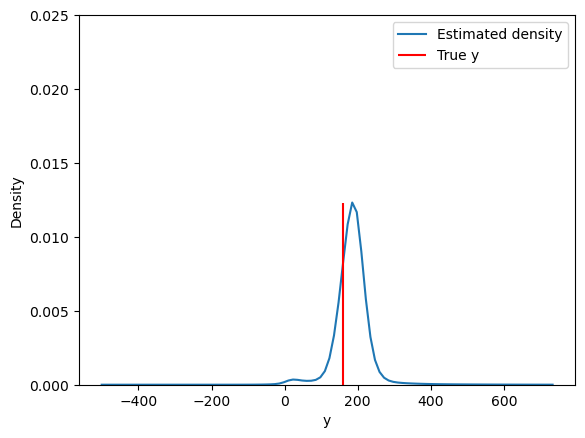

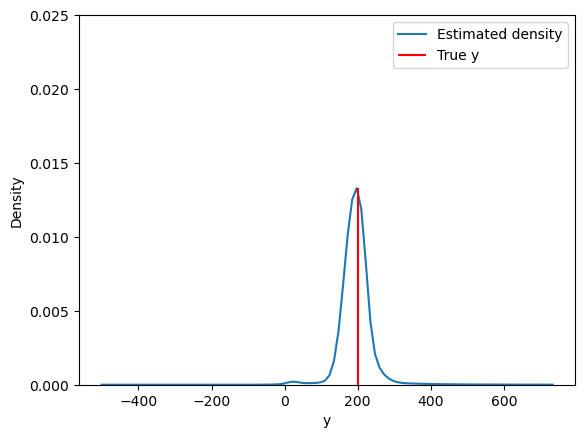

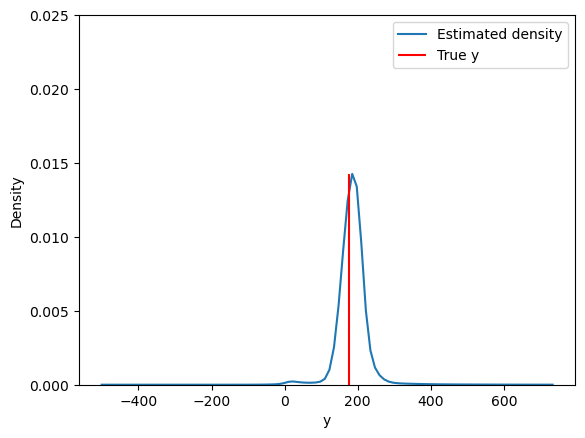

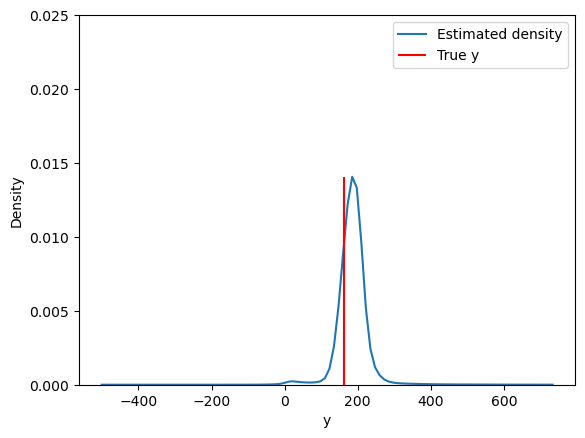

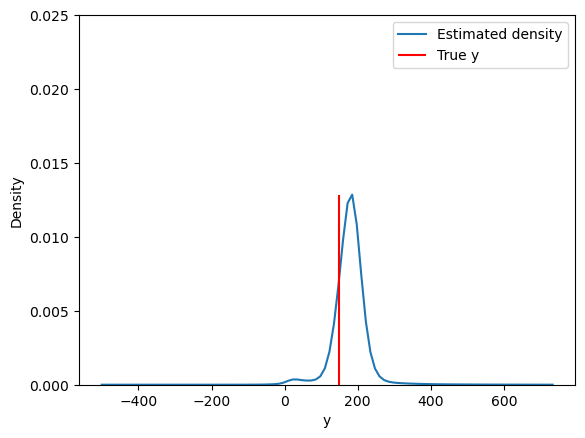

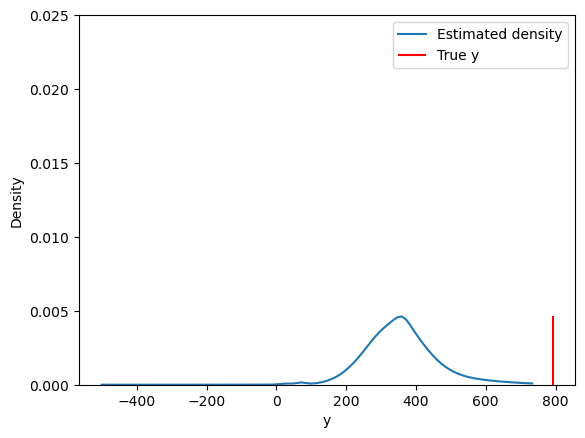

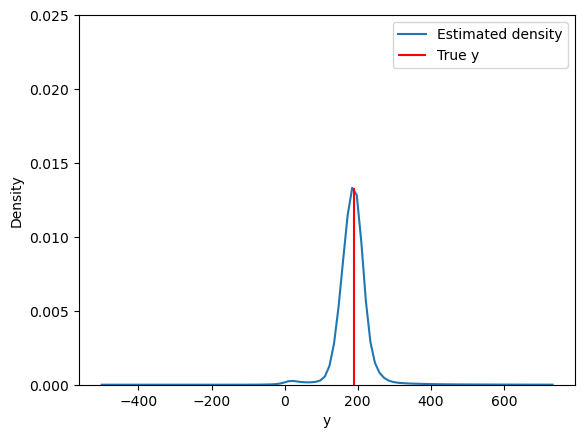

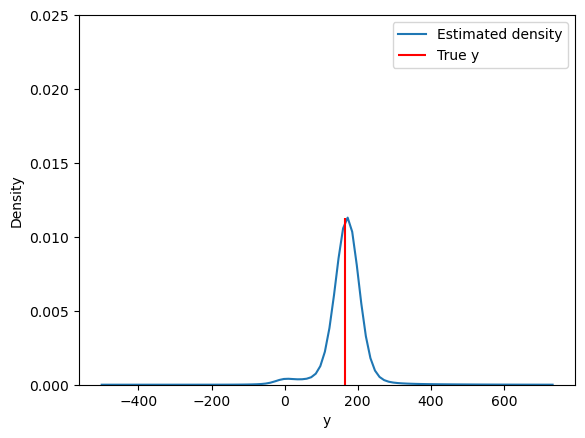

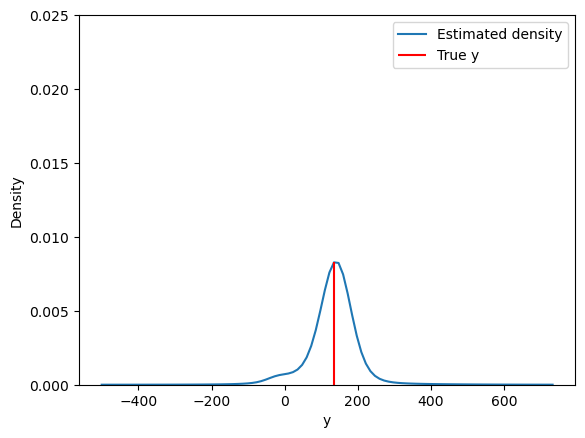

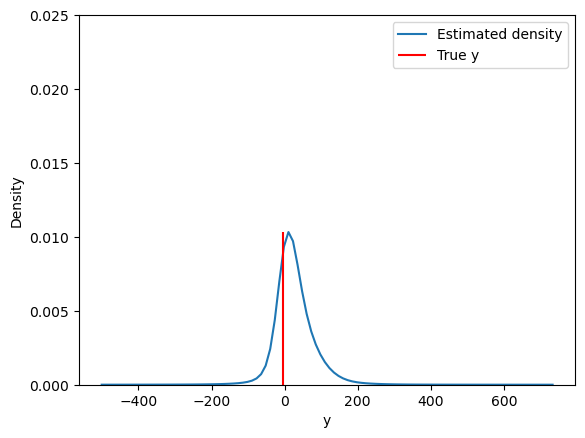

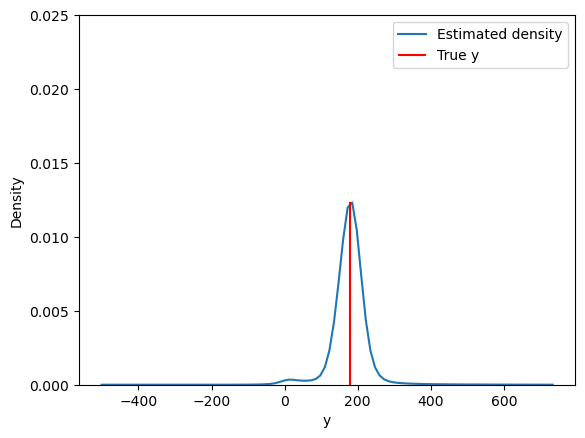

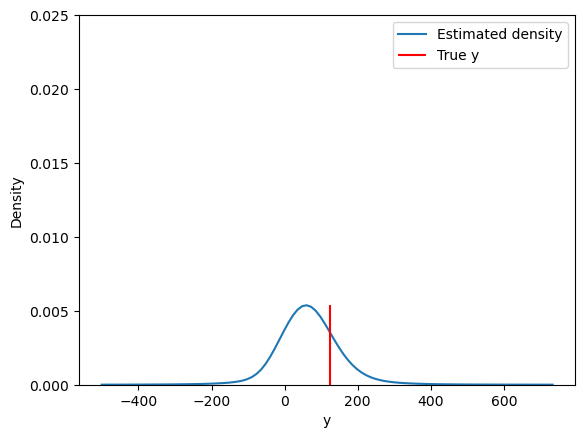

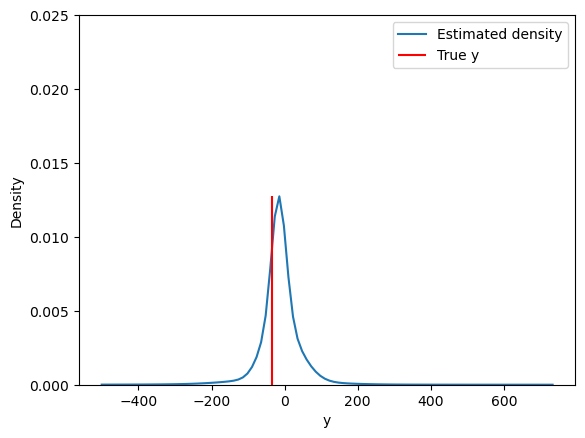

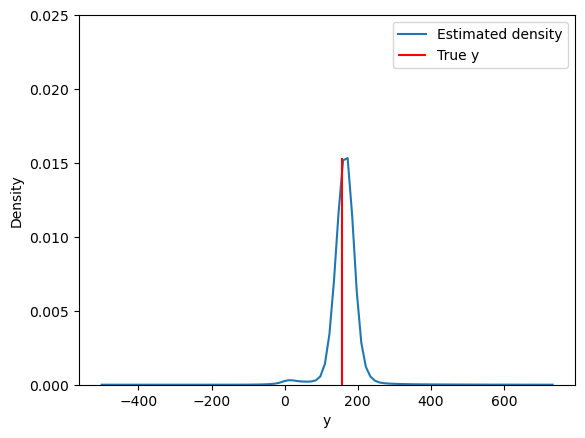

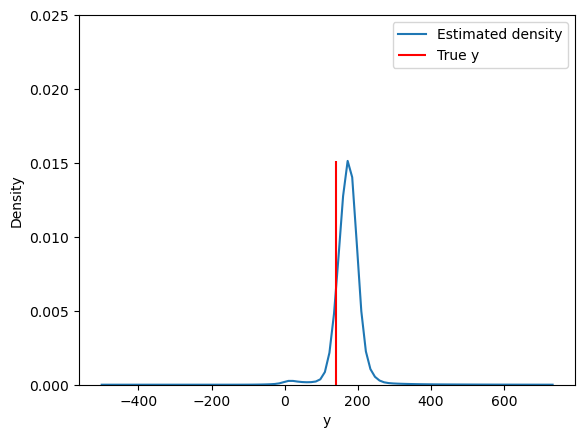

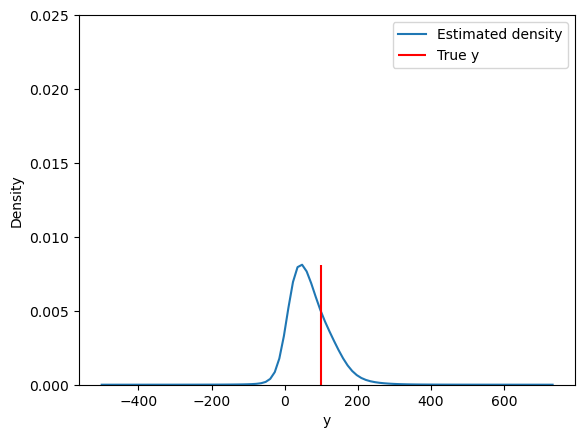

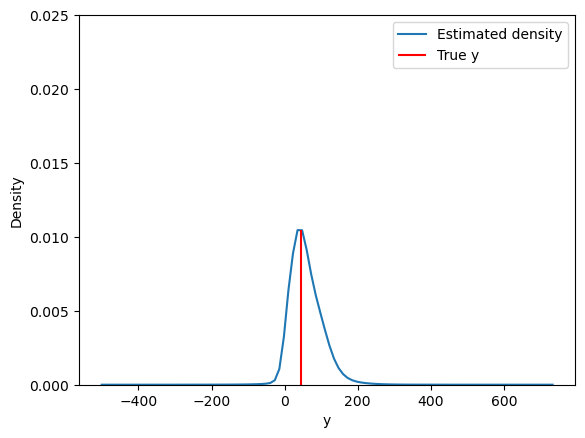

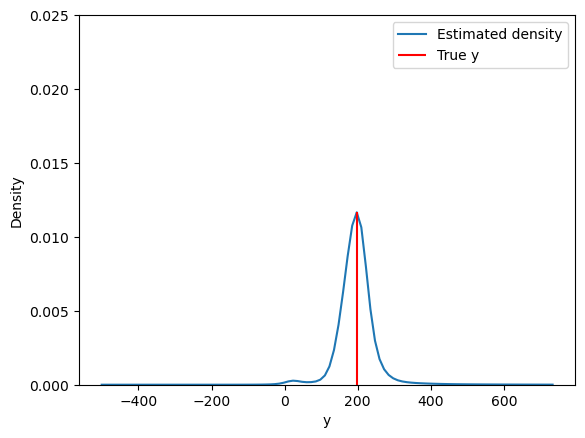

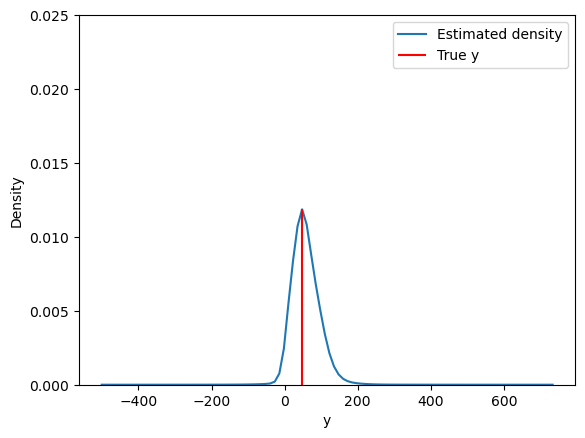

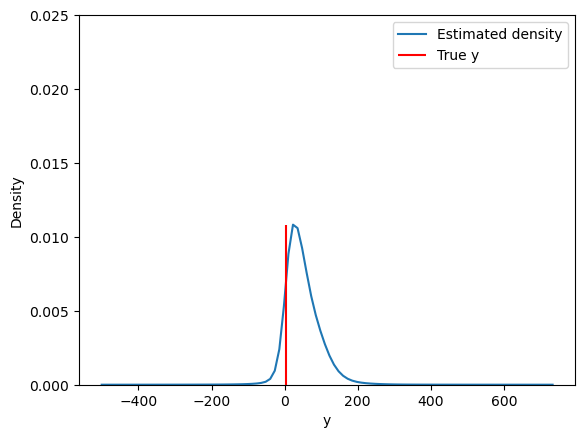

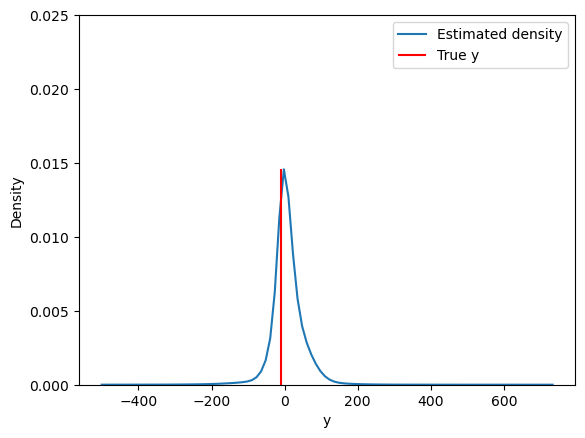

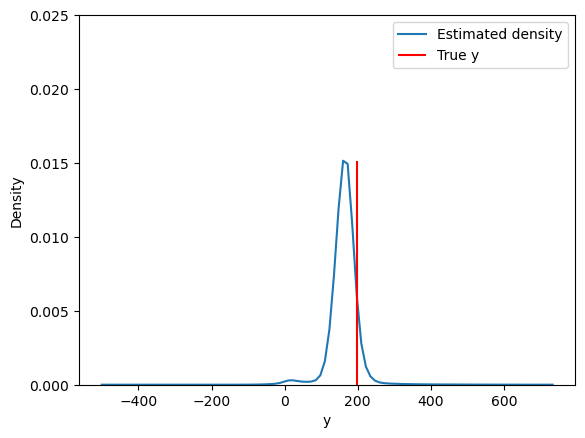

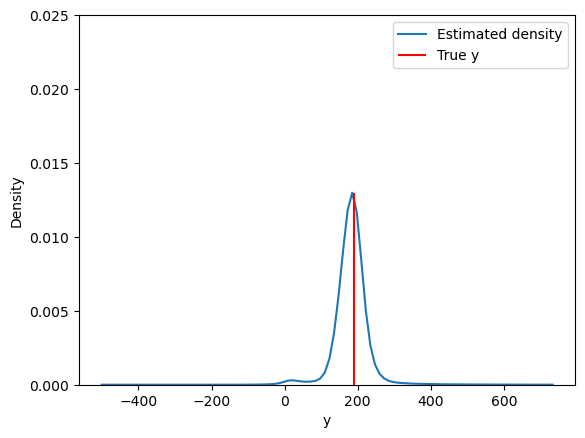

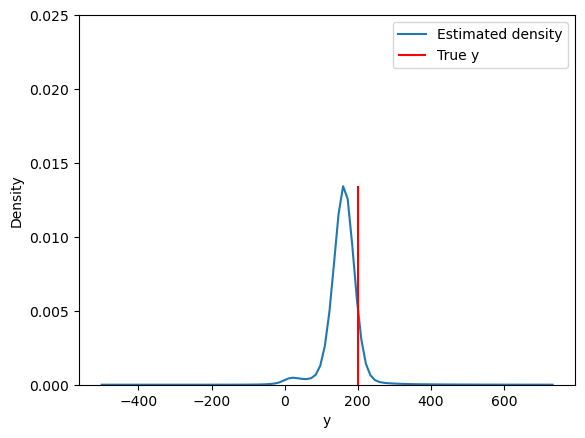

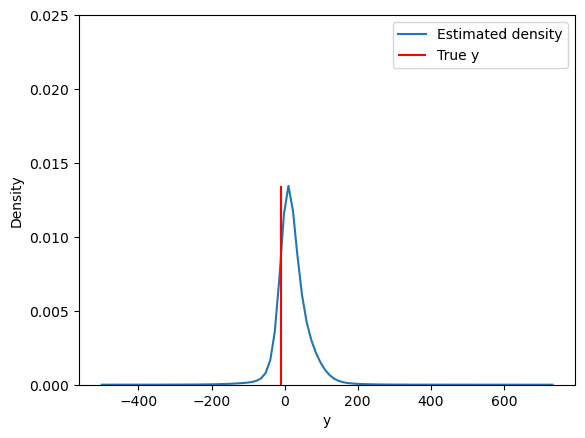

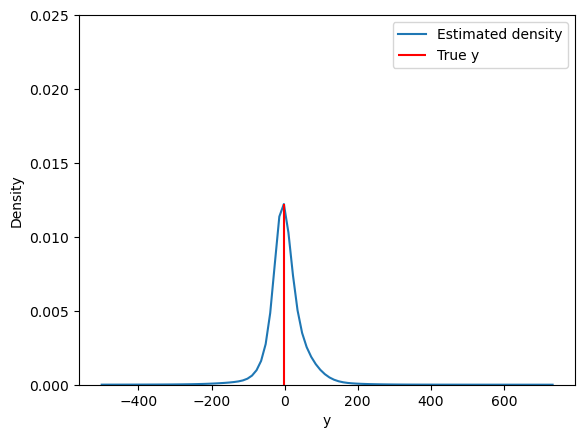

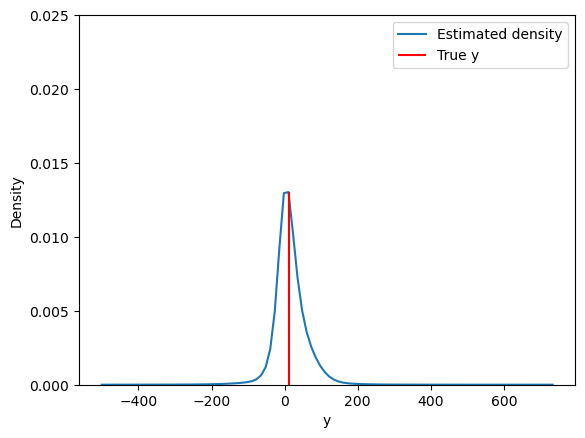

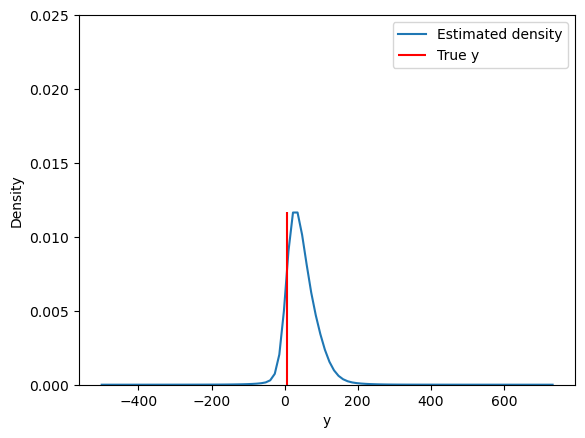

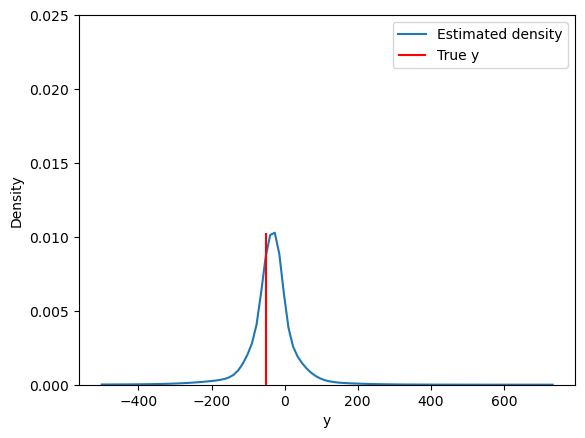

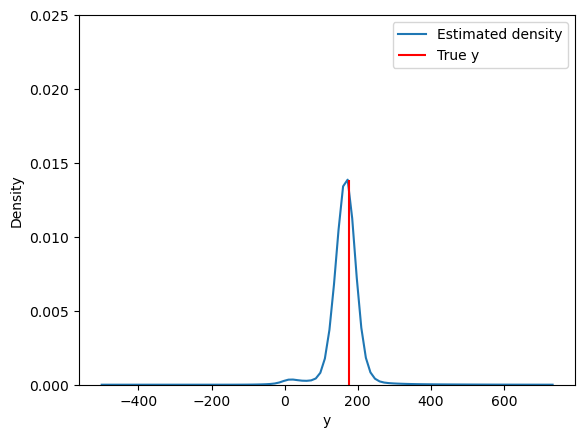

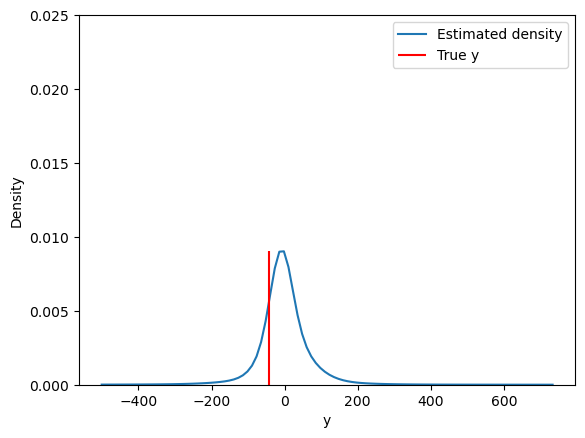

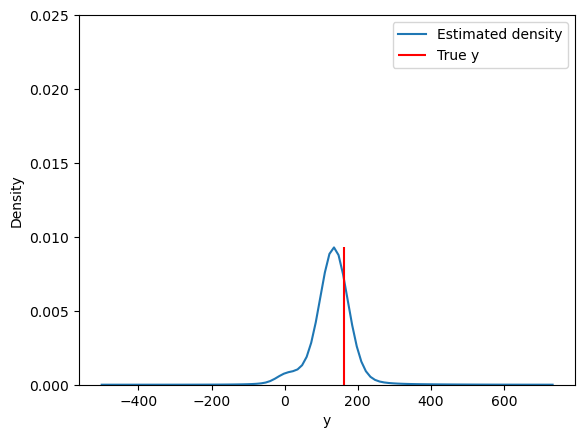

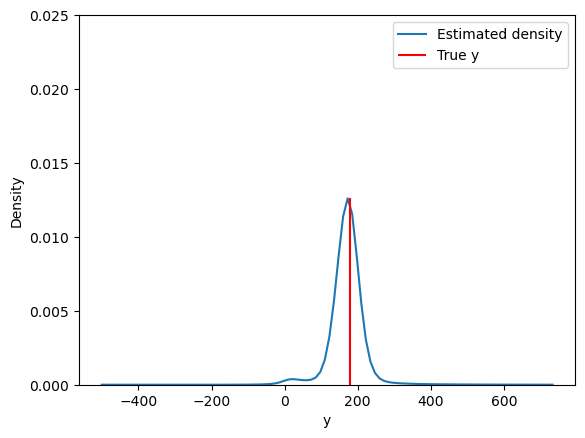

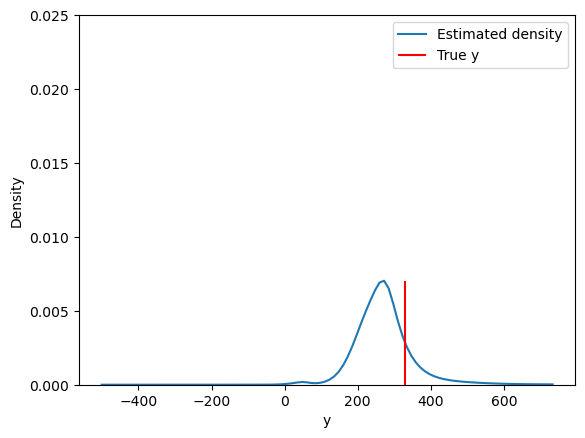

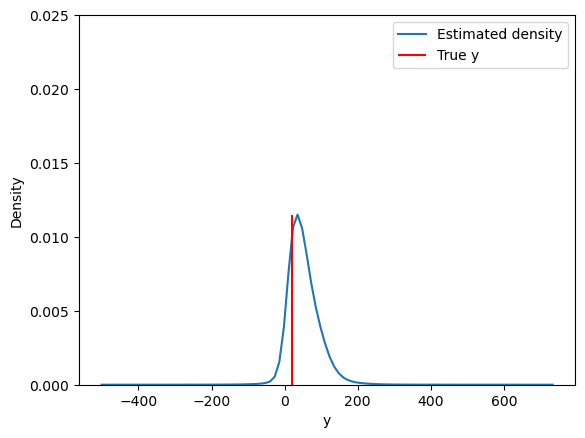

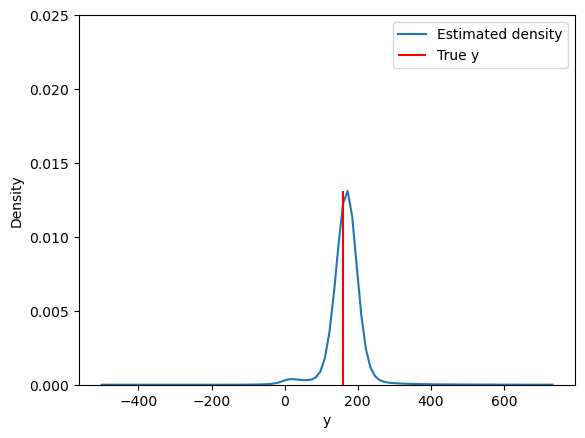

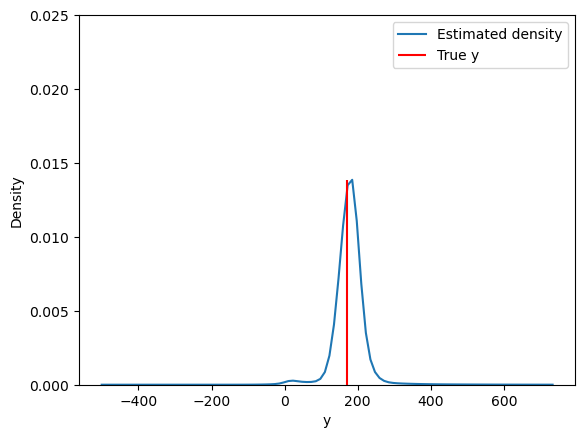

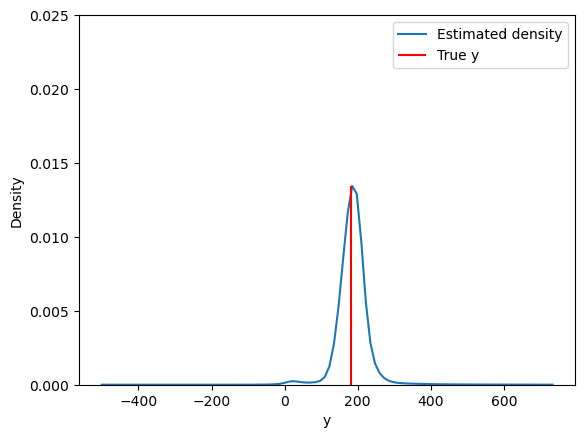

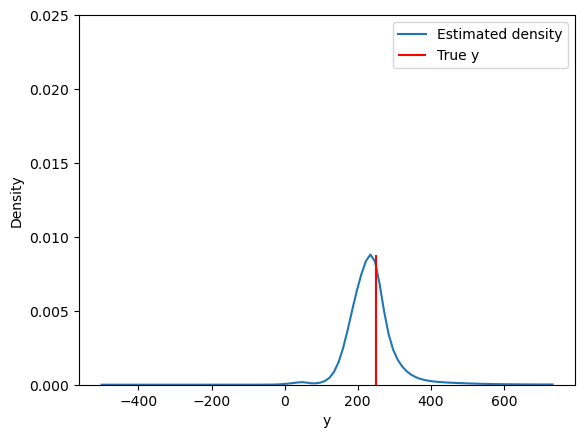

In [11]:
num_steps = 100
num_std = 1.5
max_density_for_plt = 0.025
num_samples = 150
x, y = next(iter(data_module.get_train_dataloader(num_samples, shuffle=False)))
mean_y, std_y = data_module.train_dataset.scaler_y
y_space = torch.linspace(mean_y-num_std*std_y, mean_y+num_std*std_y, num_steps, device=x.device).view(-1, 1)
precomputed_variables = model.forward(x, y)
numeric_stability = 1e-6

for idx in range(x.shape[0]):
    x_space = x[idx].unsqueeze(0).expand(num_steps, -1)
    # Calculate estimated density
    if precomputed_variables:
        to_pass_precomputed_variables = {
            key: value[idx].unsqueeze(0).expand(num_steps, -1)
            for key, value in precomputed_variables.items()
        }
        estimated_densities = model.get_density(
            x_space, y_space, numeric_stability, **to_pass_precomputed_variables
        )
    else:
        estimated_densities = model.get_density(x_space, y_space, numeric_stability)
    

    plt.plot(y_space.detach().cpu().numpy(), estimated_densities.detach().cpu().numpy(), label="Estimated density")
    plt.ylabel("Density")
    plt.xlabel("y")
    plt.vlines(y[idx].item(), 0, estimated_densities.max().item(), colors="r", label="True y")
    plt.ylim(0, max_density_for_plt)
    plt.legend()
    plt.show()

In [14]:
model.mlp.hidden_layers[2]

Linear(in_features=64, out_features=32, bias=True)

In [25]:
print(model.mlp.output_layer.weight.data.abs().max())
print(model.mlp.output_layer.bias.data.abs().max())

tensor(0.7603)
tensor(0.7925)
